# Directory settings

# About this notebook

The goal of this notebook is to improve the results of the [notebook](https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43#Train-DataLoader) shared by @cdeotte and [@alejopaullier](https://www.kaggle.com/code/alejopaullier/hms-efficientnetb0-pytorch-train), please check them out great notebooks.


**Important note**:

I shared in the last days a [discussion](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/478474) which was an Improvement of this [notebook](https://www.kaggle.com/code/nischaydnk/hms-submission-1d-eegnet-pipeline-lightning) created by @nischaydnk. The tricks I used were notably changing the optimizer (I used Adan) and I used the two stage training as stated by @seanbearden [here](https://www.kaggle.com/code/seanbearden/effnetb0-2-pop-model-train-twice-lb-0-39) and not using downsampling which worked pretty well.
But the two stage training an issue which is data leakage. The idea was to seperate the data with few votes because the kl will hardly penalize the model if it mislabel them. So in my previous experiments I use two groupkfold CV on the two datasets and the samples with few votes are present in both datasets.

So in this notebook, I use one CV scheme and in each stage I filter the data then validate on the data that contains both population to prevent data leakage. Let me know in the comment if this approach is correct more info can be found [here](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/477461).

As stated [here](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/477498), adding 0.166666667 to the targets will reduce the CV/LB gap.

**Consider upvoting this notebook if you find it useful**

## Version 1
* I train a tf_efficientnet_b0_ns model.

### Hyperparams

```
scheduler='OneCycleLR' 
 # OneCycleLR params
  cosanneal_res_params={
      'T_0':20,
      'eta_min':1e-6,
      'T_mult':1,
      'last_epoch':-1}
  print_freq=50
  num_workers = 1
  model_name = 'tf_efficientnet_b0_ns'
  optimizer='Adam'
  stage1_epochs = 5
  stage1_epochs = 6
  eps = 1e-6
  lr = 1e-3
  batch_size = 64
  weight_decay = 1e-2
  seed = 2024
```

## Version2

* I changed the CV sheme, first stage train on all data second stage train on data with `total_evaluators >= 10`
* Added Time masking augmentation from [here](https://www.kaggle.com/code/iglovikov/xymasking-aug).

In [1]:
!pip install -U albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 82.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:
      Successfully uninstalled albumentations-1.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
# ====================================================
# directory settings
# ====================================================

import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
POP_2_DIR = OUTPUT_DIR + 'pop_2_weight_oof/'
if not os.path.exists(POP_2_DIR):
    os.makedirs(POP_2_DIR)
    
POP_1_DIR = OUTPUT_DIR + 'pop_1_weight_oof/'
# POP_1_DIR = '/kaggle/input/mixmodel-weights/' + 'pop_1_weight_oof/' 
if not os.path.exists(POP_1_DIR):
    os.makedirs(POP_1_DIR)

# Libraries

In [3]:
import os
import gc
from glob import glob
import sys
import math
import time
import random
import shutil
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union
from scipy.stats import entropy
from scipy.signal import butter, lfilter, freqz
from contextlib import contextmanager
from collections import defaultdict, Counter
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss
from tqdm.auto import tqdm
from functools import partial
import cv2
from PIL import Image
import torch
from torch import Tensor
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import v2
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations import (Compose, Normalize, Resize, RandomResizedCrop, HorizontalFlip, VerticalFlip, ShiftScaleRotate, Transpose)
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
import timm
import warnings 
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from matplotlib import pyplot as plt
import joblib
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"
VERSION=2

MEAN = torch.load('/kaggle/input/mean-and-std-spectrograms/mean.pt').numpy()
STD = torch.load('/kaggle/input/mean-and-std-spectrograms/std_dev.pt').numpy()

# Config

In [4]:
# ====================================================
# CFG
# ====================================================

class CFG:
    wandb = False
    debug = False
    train=True
    apex=True
    stage1_pop1=True
    stage2_pop2=False
    VISUALIZE=True
    FREEZE=False
    SparK=False
    scheduler='OneCycleLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':6,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':20,
        'eta_min':1e-6,
        'T_mult':1,
        'last_epoch':-1
    }
    print_freq=50
    num_workers = 1
    model_name = 'tf_efficientnet_b0_ns'
    optimizer='Adan'
    epochs = 5
    factor = 0.9
    patience = 2
    eps = 1e-6
    lr = 1e-3
    min_lr = 1e-6
    batch_size = 64
    weight_decay = 1e-2
    batch_scheduler=True
    gradient_accumulation_steps = 1
    max_grad_norm = 1e7
    seed = 2024
    target_cols = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    target_size = 6
    num_channels = 8
    pred_cols = ['pred_seizure_vote', 'pred_lpd_vote', 'pred_gpd_vote', 'pred_lrda_vote', 'pred_grda_vote', 'pred_other_vote']
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    PATH = '/kaggle/input/hms-harmful-brain-activity-classification/'
    data_root = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/"
    raw_eeg_path = "/kaggle/input/brain-eegs/eegs.npy"

# Utils

In [5]:
def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def get_score(preds, targets):
    oof = pd.DataFrame(preds.copy())
    oof['id'] = np.arange(len(oof))

    true = pd.DataFrame(targets.copy())
    true['id'] = np.arange(len(true))

    cv = score(solution=true, submission=oof, row_id_column_name='id')
    return cv

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def denoise_filter(x):
    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 200.0
    lowcut = 1.0
    highcut = 25.0
    
    # Filter a noisy signal.
    T = 50
    nsamples = T * fs
    t = np.arange(0, nsamples) / fs
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    y = (y + np.roll(y,-1)+ np.roll(y,-2)+ np.roll(y,-3))/4
    y = y[0:-1:4]
    
    return y

class KLDivLossWithLogits(nn.KLDivLoss):

    def __init__(self):
        super().__init__(reduction="batchmean")

    def forward(self, y, t):
        y = nn.functional.log_softmax(y,  dim=1)
        loss = super().forward(y, t)

        return loss

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
seed_torch(seed=CFG.seed)

# Load train data

In [6]:
train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = train.columns[-6:]
print('Train shape:', train.shape )
print('Targets', list(TARGETS))

train['total_evaluators'] = train[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].sum(axis=1)

print(f'There are {train.patient_id.nunique()} patients in the training data.')
print(f'There are {train.eeg_id.nunique()} EEG IDs in the training data.')

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
There are 1950 patients in the training data.
There are 17089 EEG IDs in the training data.


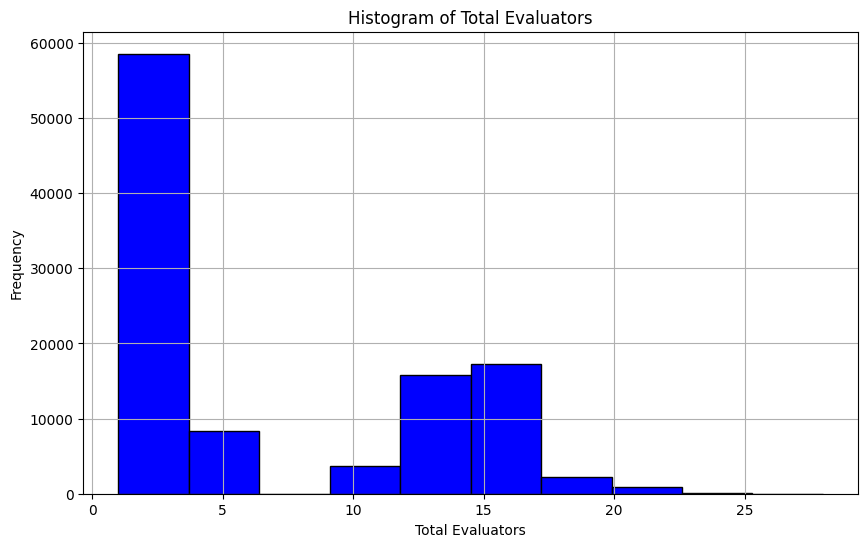

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(train['total_evaluators'], bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Total Evaluators')
plt.xlabel('Total Evaluators')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [8]:
%%time
spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy', allow_pickle=True).item()

CPU times: user 2.74 s, sys: 6.07 s, total: 8.81 s
Wall time: 1min 6s


In [9]:
%%time
all_eegs = np.load('/kaggle/input/eeg-spectrogram-by-lead-id-unique/eeg_specs.npy',allow_pickle=True).item()

CPU times: user 5.23 s, sys: 9.87 s, total: 15.1 s
Wall time: 1min 33s


In [10]:
import scipy.signal

def eeg_from_parquet(parquet_path, display=False):
    
    eeg = pd.read_parquet(parquet_path, columns=FEATS)
    rows = len(eeg)
    offset = (rows-SAMPLES)//2
    eeg = eeg.iloc[offset:offset+SAMPLES]
    
    if display: 
        plt.figure(figsize=(10,5))
        offset = 0
    
    # CONVERT TO NUMPY
    data = np.zeros((SAMPLES,len(FEATS)))
    for j,col in enumerate(FEATS):
        
        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0
        
        # Downsampling from 200 Hz to 100 Hz
        downsampled_x = scipy.signal.resample(x, SAMPLES)
        data[:, j] = downsampled_x
        
        if display: 
            if j!=0: offset += x.max()
            plt.plot(range(SAMPLES),x-offset,label=col)
            offset -= x.min()
            
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1]
        name = name.split('.')[0]
        plt.title(f'EEG {name}',size=16)
        plt.show()
        
    return data

In [11]:
SAMPLES = 5_000
CREATE_EEGS = False
FEATS = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
FEAT2IDX = {x:y for x,y in zip(FEATS,range(len(FEATS)))}

raw_eegs = {}
DISPLAY = 4
EEG_IDS = train.eeg_id.unique()
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/'
            
if CREATE_EEGS: 
    for i,eeg_id in enumerate(EEG_IDS):
        if (i%100==0)&(i!=0): print(i,', ',end='') 

        # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
        data = eeg_from_parquet(f'{PATH}{eeg_id}.parquet', display=i<DISPLAY)              
        raw_eegs[eeg_id] = data

        if i==DISPLAY:
            if CREATE_EEGS:
                print(f'Processing {train.eeg_id.nunique()} eeg parquets... ',end='')
            else:
                print(f'Reading {len(EEG_IDS)} eeg NumPys from disk.')
                break
    
    np.save('eegs',raw_eegs)
else:
    raw_eegs = np.load('/kaggle/input/brain-eegs/eegs.npy',allow_pickle=True).item()

# Deduplicate Train EEG Id

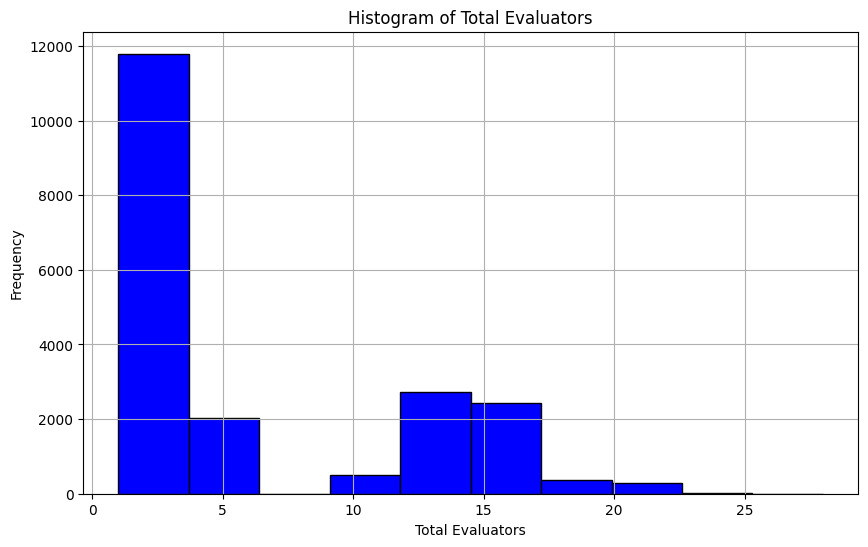

In [12]:
train = train[train['label_id'].isin(all_eegs.keys())].copy()

y_data = train[TARGETS].values +  0.166666667 # Regularization value
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

train['target'] = train['expert_consensus']

train = train.reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.hist(train['total_evaluators'], bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Total Evaluators')
plt.xlabel('Total Evaluators')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

del y_data
_ = gc.collect()

# CV Scheme

In [13]:
gkf = GroupKFold(n_splits=CFG.n_fold)

train["fold"] = -1

for fold_id, (_, val_idx) in enumerate(
    gkf.split(train, y=train["target"], groups=train["patient_id"])
):
    train.loc[val_idx, "fold"] = fold_id
    
del gkf
_ = gc.collect()

# Dataset

In [14]:
# class CustomDataset(Dataset):
#     def __init__(
#         self, df: pd.DataFrame,
#         augment: bool = False, mode: str = 'train',
#         specs: Dict[int, np.ndarray] = spectrograms,
#         eeg_specs: Dict[int, np.ndarray] = all_eegs
#     ): 
#         self.df = df
#         self.augment = augment
#         self.mode = mode
#         self.spectograms = spectrograms
#         self.eeg_spectograms = eeg_specs
        
#     def __len__(self):
#         """
#         Denotes the number of batches per epoch.
#         """
#         return len(self.df)
        
#     def __getitem__(self, index):
#         """
#         Generate one batch of data.
#         """
#         X, y = self.__data_generation(index)
#         if self.augment:
#             X = self.__transform(X) 
#         return {"spectrogram":torch.tensor(X, dtype=torch.float32), "labels":torch.tensor(y, dtype=torch.float32)}
                        
#     def __data_generation(self, index):
#         """
#         Generates data containing batch_size samples.
#         """
#         X = np.zeros((128, 256, 8), dtype='float32')
#         y = np.zeros(6, dtype='float32')
#         img = np.ones((128,256), dtype='float32')
#         row = self.df.iloc[index]
#         if self.mode=='test': 
#             r = 0
#         else: 
#             r = int(row['spectrogram_label_offset_seconds'] // 2)
            
#         for region in range(4):
#             img = self.spectograms[row.spectrogram_id][r:r+300, region*100:(region+1)*100].T
            
#             # Log transform spectogram
#             img = np.clip(img, np.exp(-4), np.exp(8))
#             img = np.log(img)

# #             # Standarize per image
# #             ep = 1e-6
# #             mu = np.nanmean(img.flatten())
# #             std = np.nanstd(img.flatten())
# #             img = (img-mu)/(std+ep)
#             img = np.nan_to_num(img, nan=0.0)
#             X[14:-14, :, region] = img[:, 22:-22] / 2.0
#             img = self.eeg_spectograms[row.label_id]
#             X[:, :, 4:] = img
            
#         if self.mode != 'test':
#             y = row[TARGETS].values.astype(np.float32)
        
#         ep = 1e-6
#         X = (X - MEAN) / (STD+ep)
#         X = np.nan_to_num(X, nan=0.0)
        
#         return X, y
    
#     def __transform(self, img):
#         params1 = {
#                     "num_masks_x": 1,    
#                     "mask_x_length": (0, 20), # This line changed from fixed  to a range
#                     "fill_value": (0, 1, 2, 3, 4, 5, 6, 7),
#                     }
#         params2 = {    
#                     "num_masks_y": 1,    
#                     "mask_y_length": (0, 20),
#                     "fill_value": (0, 1, 2, 3, 4, 5, 6, 7),    
#                     }
#         params3 = {    
#                     "num_masks_x": (2, 4),
#                     "num_masks_y": 5,    
#                     "mask_y_length": 8,
#                     "mask_x_length": (10, 20),
#                     "fill_value": (0, 1, 2, 3, 4, 5, 6, 7),  
#                     }
        
#         transforms = A.Compose([
#             A.XYMasking(**params1, p=0.3),
#             A.XYMasking(**params2, p=0.3),
#             A.XYMasking(**params3, p=0.3),
#         ])
#         return transforms(image=img)['image']

In [15]:
from scipy.signal import butter, lfilter

def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    # bins = np.linspace(-1, 1, classes)
    # quantized = np.digitize(mu_x, bins) - 1
    return mu_x#quantized

def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype="band")


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

class EEGDataset(torch.utils.data.Dataset):
    def __init__(
        self, df: pd.DataFrame,
        augment: bool = False, mode: str = 'train',
        specs: Dict[int, np.ndarray] = spectrograms,
        eeg_specs: Dict[int, np.ndarray] = all_eegs,
        eegs: Dict[int, np.ndarray] = raw_eegs
    ): 
        self.df = df
        self.augment = augment
        self.mode = mode
        self.spectograms = specs
        self.eeg_spectograms = eeg_specs
        self.eegs = eegs
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        # Processing EEG signal data
        eeg_data = self.eegs[row.eeg_id]
        sample = np.zeros((eeg_data.shape[0], 8))  # Assuming eeg_data.shape[1] == 8 for 8 channels
        FEAT2IDX = {'Fp1': 0, 'T3': 1, 'C3': 2, 'O1': 3, 'Fp2': 4, 'C4': 5, 'T4': 6, 'O2': 7}
        
        # Compute differences
        for i, (start, end) in enumerate([('Fp1', 'T3'), ('T3', 'O1'), ('Fp1', 'C3'), ('C3', 'O1'), 
                                          ('Fp2', 'C4'), ('C4', 'O2'), ('Fp2', 'T4'), ('T4', 'O2')]):
            sample[:, i] = eeg_data[:, FEAT2IDX[start]] - eeg_data[:, FEAT2IDX[end]]
        
        sample = self.process_sample(sample)
        
        samples = torch.from_numpy(sample).float()
        samples = samples.permute(1, 0)
        
        # Processing spectrogram data
        spec = self.__spec_data_generation(row)
        if self.augment:
            spec = self.__transform_2d(spec) 
        
        if self.mode != 'test':
            label = row[TARGETS]  # Assuming 'TARGETS' is defined somewhere as the label column name
            label = torch.tensor(label).float()  
            return samples, spec, label
        else:
            return samples, spec
    
    def process_sample(self, sample):
        # Normalize the sample data
        sample = (sample - np.mean(sample, axis=0)) / np.std(sample, axis=0)  # Possibly make this global
        sample = np.clip(sample, -1024, 1024)
        sample = np.nan_to_num(sample, nan=0)
        sample = butter_bandpass_filter(sample, 0.5, 25, 100) # Change is the downsampling is changed
        sample = quantize_data(sample, 1)
        return sample

    def __spec_data_generation(self, row):
        """
        Generates data containing batch_size samples. This method directly
        uses class attributes for spectrograms and EEG spectrograms.
        """
        X = np.zeros((128, 256, 8), dtype='float32')        
        if self.mode != 'test':
            # Assuming your DataFrame has a column that combines min and max values for slicing
            r = int(row['spectrogram_label_offset_seconds'] // 2)
        else:
            r = 0  # Adjust as necessary for test mode
        
        for region in range(4):
            img = self.spectograms[row.spectrogram_id][r:r+300, region*100:(region+1)*100].T
            
            # Log transform spectogram
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)
            
#             ep = 1e-6
#             mu = np.nanmean(img.flatten())
#             std = np.nanstd(img.flatten())
#             img = (img-mu)/(std+ep)
            img = np.nan_to_num(img, nan=0.0)
            X[14:-14, :, region] = img[:, 22:-22] / 2.0
            img = self.eeg_spectograms[row.label_id]
            X[:, :, 4:] = img
            
        ep = 1e-6
        X = (X - MEAN) / (STD+ep)
        X = np.nan_to_num(X, nan=0.0)
                 
        return X

    def __transform_2d(self, img):
        params1 = {
                    "num_masks_x": 1,    
                    "mask_x_length": (0, 20), # This line changed from fixed  to a range
                    "fill_value": (0, 1, 2, 3, 4, 5, 6, 7),
                    }
        params2 = {    
                    "num_masks_y": 1,    
                    "mask_y_length": (0, 20),
                    "fill_value": (0, 1, 2, 3, 4, 5, 6, 7),    
                    }
        params3 = {    
                    "num_masks_x": (2, 4),
                    "num_masks_y": 5,    
                    "mask_y_length": 8,
                    "mask_x_length": (10, 20),
                    "fill_value": (0, 1, 2, 3, 4, 5, 6, 7),  
                    }
        
        transforms = A.Compose([
            A.XYMasking(**params1, p=0.3),
            A.XYMasking(**params2, p=0.3),
            A.XYMasking(**params3, p=0.3),
        ])
        return transforms(image=img)['image']

# Dataloader

In [16]:
# dataset = CustomDataset(train, augment=False, mode="train")
# dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# batch = dataset[4]
# X, y = batch["spectrogram"], batch["labels"]
# print(f"X shape: {X.shape}")
# print(f"y shape: {y.shape}")

# plt.imshow(X[:,:,0])

# del dataset, X, y
# _ = gc.collect()

In [17]:
# dataset = CustomDataset(train, augment=False, mode="train")
# dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

# batch = dataset[0]
# X, y = batch["spectrogram"], batch["labels"]

# total_sum_mean = torch.zeros(X.shape)
# total_samples_mean = 0

# total_sum_var = torch.zeros(X.shape)
# total_samples_var = 0

# for i, batch in enumerate(dataloader):
#     if i%10==0: print(i, end=", ")
#     X = batch["spectrogram"]
    
#     total_sum_mean += torch.sum(X, dim=0)
#     total_samples_mean += X.size(0)

# # Compute mean
# mean = total_sum_mean / total_samples_mean
# torch.save(mean, 'mean.pt')

# for i, batch in enumerate(dataloader):
#     if i%10==0: print(i, end=", ")
#     X = batch["spectrogram"]
    
#     total_sum_var += torch.sum((X - mean) ** 2, dim=0)
#     total_samples_var += X.size(0)
    
# std_dev = torch.sqrt(total_sum_var / total_samples_var)
# torch.save(std_dev, 'std_dev.pt')  

In [18]:
dataset = EEGDataset(train, augment=True, mode="train")
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

samples, spec, label = dataset[0]

print(f"Samples shape: {samples.shape}")
print(f"Spec shape: {spec.shape}")
print(f"Label shape: {label.shape}")

del dataset, samples, spec, label
_ = gc.collect()

Samples shape: torch.Size([8, 5000])
Spec shape: (128, 256, 8)
Label shape: torch.Size([6])


In [19]:
# if CFG.VISUALIZE:
#     ROWS = 2
#     COLS = 3
#     for batch in dataloader:
#         X, y = batch["spectrogram"], batch["labels"]
#         plt.figure(figsize=(20,8))
#         for row in range(ROWS):
#             for col in range(COLS):
#                 plt.subplot(ROWS, COLS, row*COLS + col+1)
#                 t = y[row*COLS + col]
#                 img = X[row*COLS + col, :, :, 0]
#                 mn = img.flatten().min()
#                 mx = img.flatten().max()
#                 img = (img-mn)/(mx-mn)
#                 plt.imshow(img)
#                 tars = f'[{t[0]:0.2f}'
#                 for s in t[1:]:
#                     tars += f', {s:0.2f}'
#                 eeg = train.eeg_id.values[row*CFG.batch_size + row*COLS + col]
#                 plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
#                 plt.yticks([])
#                 plt.ylabel('Frequencies (Hz)',size=14)
#                 plt.xlabel('Time (sec)',size=16)
#         plt.show()
#         break
        
# del dataloader
# _ = gc.collect()

# Model

In [20]:
# class CustomModel(nn.Module):
#     def __init__(self, config, num_classes: int = 6, pretrained: bool = True):
#         super(CustomModel, self).__init__()
#         self.USE_KAGGLE_SPECTROGRAMS = True
#         self.USE_EEG_SPECTROGRAMS = True
#         self.model = timm.create_model(
#             config.model_name,
#             pretrained=pretrained,
#         )
#         if config.FREEZE:
#             for i,(name, param) in enumerate(list(self.model.named_parameters())\
#                                              [0:config.NUM_FROZEN_LAYERS]):
#                 param.requires_grad = False

#         self.features = nn.Sequential(*list(self.model.children())[:-2])
#         self.custom_layers = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1),
#             nn.Flatten(),
#             nn.Linear(self.model.num_features, num_classes)
#         )

#     def __reshape_input(self, x):
#         """
#         Reshapes input (128, 256, 8) -> (512, 512, 3) monotone image.
#         """ 
#         # === Get spectograms ===
#         spectograms = [x[:, :, :, i:i+1] for i in range(4)]
#         spectograms = torch.cat(spectograms, dim=1)
        
#         # === Get EEG spectograms ===
#         eegs = [x[:, :, :, i:i+1] for i in range(4,8)]
#         eegs = torch.cat(eegs, dim=1)
        
#         # === Reshape (512,512,3) ===
#         if self.USE_KAGGLE_SPECTROGRAMS & self.USE_EEG_SPECTROGRAMS:
#             x = torch.cat([spectograms, eegs], dim=2)
#         elif self.USE_EEG_SPECTROGRAMS:
#             x = eegs
#         else:
#             x = spectograms
            
#         x = torch.cat([x,x,x], dim=3)
#         x = x.permute(0, 3, 1, 2)
#         return x
    
#     def forward(self, x):
#         x = self.__reshape_input(x)
#         x = self.features(x)
#         x = self.custom_layers(x)
#         return x

In [21]:
class _WaveBlock(nn.Module):
    """WaveNet block.

    Args:
        kernel_size: kernel size, pass a list of kernel sizes for
            inception
    """

    def __init__(
        self,
        n_layers: int, 
        in_dim: int,
        h_dim: int,
        kernel_size: Union[int, List[int]],
        conv_module: Optional[Type[nn.Module]] = None,
    ) -> None:
        super().__init__()

        self.n_layers = n_layers
        self.dilation_rates = [2**l for l in range(n_layers)]

        self.in_conv = nn.Conv2d(in_dim, h_dim, kernel_size=(1, 1)) 
        self.gated_tcns = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        for layer in range(n_layers):
            c_in, c_out = h_dim, h_dim
            self.gated_tcns.append(
                _GatedTCN(
                    in_dim=c_in,
                    h_dim=c_out,
                    kernel_size=kernel_size,
                    dilation_factor=self.dilation_rates[layer],
                    conv_module=conv_module,
                )
            )
            self.skip_convs.append(nn.Conv2d(h_dim, h_dim, kernel_size=(1, 1)))

        # Initialize parameters
        nn.init.xavier_uniform_(self.in_conv.weight, gain=nn.init.calculate_gain("relu"))
        nn.init.zeros_(self.in_conv.bias)
        for i in range(len(self.skip_convs)):
            nn.init.xavier_uniform_(self.skip_convs[i].weight, gain=nn.init.calculate_gain("relu"))
            nn.init.zeros_(self.skip_convs[i].bias)

    def forward(self, x: Tensor) -> Tensor:
        """Forward pass.
        
        Shape:
            x: (B, C, N, L), where C denotes in_dim
            x_skip: (B, C', N, L), where C' denotes h_dim
        """
        # Input convolution
        x = self.in_conv(x)

        x_skip = x
        for layer in range(self.n_layers):
            x = self.gated_tcns[layer](x)
            x = self.skip_convs[layer](x)

            # Skip-connection
            x_skip = x_skip + x 

        return x_skip


class _GatedTCN(nn.Module):
    """Gated temporal convolution layer.

    Parameters:
        conv_module: customized convolution module
    """

    def __init__(
        self,
        in_dim: int,
        h_dim: int,
        kernel_size: Union[int, List[int]],
        dilation_factor: int,
        dropout: Optional[float] = None,
        conv_module: Optional[Type[nn.Module]] = None,
    ) -> None:
        super().__init__()

        # Model blocks
        if conv_module is None:
            self.filt = nn.Conv2d(
                in_channels=in_dim, out_channels=h_dim, kernel_size=(1, kernel_size), dilation=dilation_factor
            )
            self.gate = nn.Conv2d(
                in_channels=in_dim, out_channels=h_dim, kernel_size=(1, kernel_size), dilation=dilation_factor
            )
        else:
            self.filt = conv_module(
                in_channels=in_dim, out_channels=h_dim, kernel_size=kernel_size, dilation=dilation_factor
            )
            self.gate = conv_module(
                in_channels=in_dim, out_channels=h_dim, kernel_size=kernel_size, dilation=dilation_factor
            )

        if dropout is not None:
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = None

    def forward(self, x: Tensor) -> Tensor:
        """Forward pass.

        Parameters:
            x: input sequence

        Return:
            h: output sequence

        Shape:
            x: (B, C, N, L), where L denotes the input sequence length
            h: (B, h_dim, N, L')
        """
        x_filt = F.tanh(self.filt(x))
        x_gate = F.sigmoid(self.gate(x))
        h = x_filt * x_gate
        if self.dropout is not None:
            h = self.dropout(h)

        return h


class _DilatedInception(nn.Module):
    """Dilated inception layer.

    Note that `out_channels` will be split across #kernels.
    """

    def __init__(
        self, 
        in_channels: int, 
        out_channels: int, 
        kernel_size: List[int], 
        dilation: int
    ) -> None:
        super().__init__()

        # Network parameters
        n_kernels = len(kernel_size)
        assert out_channels % n_kernels == 0, "`out_channels` must be divisible by #kernels."
        h_dim = out_channels // n_kernels

        # Model blocks
        self.convs = nn.ModuleList()
        for k in kernel_size:
            self.convs.append(
                nn.Conv2d(
                    in_channels=in_channels, 
                    out_channels=h_dim, 
                    kernel_size=(1, k),
                    padding="same",
                    dilation=dilation),
            )

    def forward(self, x: Tensor) -> Tensor:
        """Forward pass.

        Parameters:
            x: input sequence

        Return:
            h: output sequence

        Shape:
            x: (B, C, N, L), where C = in_channels
            h: (B, C', N, L'), where C' = out_channels
        """
        x_convs = []
        for conv in self.convs:
            x_conv = conv(x)
            x_convs.append(x_conv)
        h = torch.cat(x_convs, dim=1)

        return h
    

class EEGMegaNet(nn.Module):

    def __init__(self, backbone_2d,in_channels_2d, pretrained=True, in_channels=20, num_classes=6):
        super(EEGMegaNet, self).__init__()
        
        # EfficientNet
#         self.kernels = kernels
#         self.planes = 24
        self.parallel_conv = nn.ModuleList()
        self.in_channels = in_channels

        self.backbone_2d = timm.create_model(
            backbone_2d,
            pretrained=pretrained,
            drop_rate = 0.1,
            drop_path_rate = 0.1
        )
        
        self.features_2d = nn.Sequential(*list(self.backbone_2d.children())[:-2] + [nn.AdaptiveAvgPool2d(1),nn.Flatten()])
            
        # WaveNet DilatedInception
        kernel_size = [2, 3, 6, 7]

        self.wave_module = nn.Sequential(
            _WaveBlock(12, 1, 16, kernel_size, _DilatedInception),
            _WaveBlock(8, 16, 32, kernel_size, _DilatedInception),
            _WaveBlock(4, 32, 64, kernel_size, _DilatedInception),
            _WaveBlock(1, 64, 64, kernel_size, _DilatedInception),
        )
        
#         for i, kernel_size in enumerate(list(self.kernels)):
#             sep_conv = nn.Conv1d(in_channels=in_channels, out_channels=self.planes, kernel_size=(kernel_size),
#                                stride=1, padding=0, bias=False,)
#             self.parallel_conv.append(sep_conv)

#         self.bn1 = nn.BatchNorm1d(num_features=self.planes)
#         self.relu = nn.ReLU(inplace=False)
#         self.conv1 = nn.Conv1d(in_channels=self.planes, out_channels=self.planes, kernel_size=fixed_kernel_size,
#                                stride=2, padding=2, bias=False)
#         self.block = self._make_resnet_layer(kernel_size=fixed_kernel_size, stride=1, padding=fixed_kernel_size//2)
#         self.bn2 = nn.BatchNorm1d(num_features=self.planes)
#         self.avgpool = nn.AvgPool1d(kernel_size=4, stride=4, padding=2)
#         self.rnn = nn.GRU(input_size=self.in_channels, hidden_size=128, num_layers=1, bidirectional=True)
        
        self.fc1 = nn.Linear(in_features=1280, out_features=128)
        self.fc2 = nn.Linear(in_features=4*64, out_features=128)
        self.fc = nn.Linear(in_features=256, out_features=num_classes)

        self.fc1d = nn.Linear(in_features=128, out_features=num_classes)
        self.fc2d = nn.Linear(in_features=128, out_features=num_classes)
        
        
#         self.rnn1 = nn.GRU(input_size=156, hidden_size=156, num_layers=1, bidirectional=True)

#     def _make_resnet_layer(self, kernel_size, stride, blocks=8, padding=0):
#         layers = []
#         downsample = None
#         base_width = self.planes

#         for i in range(blocks):
#             downsampling = nn.Sequential(
#                     nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#                 )
#             layers.append(ResNet_1D_Block(in_channels=self.planes, out_channels=self.planes, kernel_size=kernel_size,
#                                        stride=stride, padding=padding, downsampling=downsampling))

#         return nn.Sequential(*layers)

    def _reshape_input(self, spec):
        """
        Reshapes input (128, 256, 8) -> (512, 512, 3) monotone image.
        """ 
        # === Get spectograms ===
        spectograms = [spec[:, :, :, i:i+1] for i in range(4)]
        spectograms = torch.cat(spectograms, dim=1)
        
        # === Get EEG spectograms ===
        eegs = [spec[:, :, :, i:i+1] for i in range(4,8)]
        eegs = torch.cat(eegs, dim=1)
        
        # === Reshape (512,512,3) ===
        spec = spectograms
            
        spec = torch.cat([spec,spec,spec], dim=3)
        spec = spec.permute(0, 3, 1, 2)
        return spec

    def forward(self, x, spec):
        
        
        spec = self._reshape_input(spec)
        spec = self.features_2d(spec)
        
        bs, length, in_dim = x.shape
        x = x.transpose(1, 2).unsqueeze(dim=2)

        x_ll_1 = self.wave_module(x[:, 0:1, :])
        x_ll_2 = self.wave_module(x[:, 1:2, :])
        x_ll = (F.adaptive_avg_pool2d(x_ll_1, (1, 1)) + F.adaptive_avg_pool2d(x_ll_2, (1, 1))) / 2

        x_rl_1 = self.wave_module(x[:, 2:3, :])
        x_rl_2 = self.wave_module(x[:, 3:4, :])
        x_rl = (F.adaptive_avg_pool2d(x_rl_1, (1, 1)) + F.adaptive_avg_pool2d(x_rl_2, (1, 1))) / 2

        x_lp_1 = self.wave_module(x[:, 4:5, :])
        x_lp_2 = self.wave_module(x[:, 5:6, :])
        x_lp = (F.adaptive_avg_pool2d(x_lp_1, (1, 1)) + F.adaptive_avg_pool2d(x_lp_2, (1, 1))) / 2

        x_rp_1 = self.wave_module(x[:, 6:7, :])
        x_rp_2 = self.wave_module(x[:, 7:8, :])
        x_rp = (F.adaptive_avg_pool2d(x_rp_1, (1, 1)) + F.adaptive_avg_pool2d(x_rp_2, (1, 1))) / 2

        new_out = torch.cat([x_ll, x_rl, x_lp, x_rp], axis=1).reshape(bs, -1)
        
        
#         # print(spec.shape) #2, 1280, 16, 8
#         out_sep = []

#         for i in range(len(self.kernels)):
#             sep = self.parallel_conv[i](x)
#             out_sep.append(sep)

#         out = torch.cat(out_sep, dim=2)
#         out = self.bn1(out)
#         out = self.relu(out)
#         out = self.conv1(out)  

#         out = self.block(out)
#         out = self.bn2(out)
#         out = self.relu(out)
#         out = self.avgpool(out)  


#         out = out.reshape(out.shape[0], -1)  

#         rnn_out, _ = self.rnn(x.permute(0,2, 1))
#         new_rnn_h = rnn_out[:, -1, :]  

#         new_out = torch.cat([out, new_rnn_h], dim=1)


        new_out = self.fc2(new_out)  
        out1d = self.fc1d(new_out)
        
        spec = self.fc1(spec)  
        out2d = self.fc2d(spec)
        
        result = torch.cat([new_out, spec], dim=1)  
        result = self.fc(result)
        
        return result

In [22]:
# iot = torch.randn(2, 128, 256, 8)
# model = CustomModel(CFG)
# output = model(iot)
# print(output.shape)

# del iot, model, output
# gc.collect()
# torch.cuda.empty_cache()

In [23]:
iot = torch.randn(2, CFG.num_channels, 5_000)#.cuda()
spec = torch.randn(2, 128, 256, 8)#.cuda()

model = EEGMegaNet(backbone_2d=CFG.model_name,
                   in_channels_2d=8,
                   pretrained=False,
                   in_channels=CFG.num_channels,
                   num_classes=CFG.target_size)

output = model(iot, spec)
print(output.shape)

del iot, model
gc.collect()
torch.cuda.empty_cache()

torch.Size([2, 6])


# Adan Optimizer

In [24]:
import math
import torch
from torch.optim.optimizer import Optimizer


class Adan(Optimizer):
    """
    Implements a pytorch variant of Adan
    Adan was proposed in
    Adan: Adaptive Nesterov Momentum Algorithm for Faster Optimizing Deep Models[J]. arXiv preprint arXiv:2208.06677, 2022.
    https://arxiv.org/abs/2208.06677
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining parameter groups.
        lr (float, optional): learning rate. (default: 1e-3)
        betas (Tuple[float, float, flot], optional): coefficients used for computing 
            running averages of gradient and its norm. (default: (0.98, 0.92, 0.99))
        eps (float, optional): term added to the denominator to improve 
            numerical stability. (default: 1e-8)
        weight_decay (float, optional): decoupled weight decay (L2 penalty) (default: 0)
        max_grad_norm (float, optional): value used to clip 
            global grad norm (default: 0.0 no clip)
        no_prox (bool): how to perform the decoupled weight decay (default: False)
    """

    def __init__(self, params, lr=1e-3, betas=(0.98, 0.92, 0.99), eps=1e-8,
                 weight_decay=0.2, max_grad_norm=0.0, no_prox=False):
        if not 0.0 <= max_grad_norm:
            raise ValueError("Invalid Max grad norm: {}".format(max_grad_norm))
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= betas[2] < 1.0:
            raise ValueError("Invalid beta parameter at index 2: {}".format(betas[2]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay,
                        max_grad_norm=max_grad_norm, no_prox=no_prox)
        super(Adan, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adan, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('no_prox', False)

    @torch.no_grad()
    def restart_opt(self):
        for group in self.param_groups:
            group['step'] = 0
            for p in group['params']:
                if p.requires_grad:
                    state = self.state[p]
                    # State initialization

                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    # Exponential moving average of gradient difference
                    state['exp_avg_diff'] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self):
        """
            Performs a single optimization step.
        """
        if self.defaults['max_grad_norm'] > 0:
            device = self.param_groups[0]['params'][0].device
            global_grad_norm = torch.zeros(1, device=device)

            max_grad_norm = torch.tensor(self.defaults['max_grad_norm'], device=device)
            for group in self.param_groups:

                for p in group['params']:
                    if p.grad is not None:
                        grad = p.grad
                        global_grad_norm.add_(grad.pow(2).sum())

            global_grad_norm = torch.sqrt(global_grad_norm)

            clip_global_grad_norm = torch.clamp(max_grad_norm / (global_grad_norm + group['eps']), max=1.0)
        else:
            clip_global_grad_norm = 1.0

        for group in self.param_groups:
            beta1, beta2, beta3 = group['betas']
            # assume same step across group now to simplify things
            # per parameter step can be easily support by making it tensor, or pass list into kernel
            if 'step' in group:
                group['step'] += 1
            else:
                group['step'] = 1

            bias_correction1 = 1.0 - beta1 ** group['step']

            bias_correction2 = 1.0 - beta2 ** group['step']

            bias_correction3 = 1.0 - beta3 ** group['step']

            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]
                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    state['exp_avg_diff'] = torch.zeros_like(p)

                grad = p.grad.mul_(clip_global_grad_norm)
                if 'pre_grad' not in state or group['step'] == 1:
                    state['pre_grad'] = grad

                copy_grad = grad.clone()

                exp_avg, exp_avg_sq, exp_avg_diff = state['exp_avg'], state['exp_avg_sq'], state['exp_avg_diff']
                diff = grad - state['pre_grad']

                update = grad + beta2 * diff
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)  # m_t
                exp_avg_diff.mul_(beta2).add_(diff, alpha=1 - beta2)  # diff_t
                exp_avg_sq.mul_(beta3).addcmul_(update, update, value=1 - beta3)  # n_t

                denom = ((exp_avg_sq).sqrt() / math.sqrt(bias_correction3)).add_(group['eps'])
                update = ((exp_avg / bias_correction1 + beta2 * exp_avg_diff / bias_correction2)).div_(denom)

                if group['no_prox']:
                    p.data.mul_(1 - group['lr'] * group['weight_decay'])
                    p.add_(update, alpha=-group['lr'])
                else:
                    p.add_(update, alpha=-group['lr'])
                    p.data.div_(1 + group['lr'] * group['weight_decay'])

                state['pre_grad'] = copy_grad

# Helper functions

In [25]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


# def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
#     model.train()
#     scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
#     losses = AverageMeter()
#     start = end = time.time()
#     global_step = 0
#     for step, batch in enumerate(train_loader):
#         spectrogram = batch['spectrogram'].to(device)
#         labels = batch['labels'].to(device)
#         batch_size = labels.size(0)
#         with torch.cuda.amp.autocast(enabled=CFG.apex):
#             y_preds= model(spectrogram)
#             loss = criterion(F.log_softmax(y_preds, dim=1), labels)
#         if CFG.gradient_accumulation_steps > 1:
#             loss = loss / CFG.gradient_accumulation_steps
#         losses.update(loss.item(), batch_size)
#         scaler.scale(loss).backward()
#         grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
#         if (step + 1) % CFG.gradient_accumulation_steps == 0:
#             scaler.step(optimizer)
#             scaler.update()
#             optimizer.zero_grad()
#             global_step += 1
#             if CFG.batch_scheduler:
#                 scheduler.step()
#         end = time.time()
#         if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
#             print('Epoch: [{0}][{1}/{2}] '
#                   'Elapsed {remain:s} '
#                   'Loss: {loss.val:.4f}({loss.avg:.4f}) '
#                   'Grad: {grad_norm:.4f}  '
#                   'LR: {lr:.8f}  '
#                   .format(epoch+1, step, len(train_loader), 
#                           remain=timeSince(start, float(step+1)/len(train_loader)),
#                           loss=losses,
#                           grad_norm=grad_norm,
#                           lr=scheduler.get_lr()[0]))
#         if CFG.wandb:
#             wandb.log({f"[fold{fold}] loss": losses.val,
#                        f"[fold{fold}] lr": scheduler.get_lr()[0]})
#     return losses.avg


# def valid_fn(valid_loader, model, criterion, device):
#     losses = AverageMeter()
#     model.eval()
#     preds = []
#     start = end = time.time()
#     for step, batch in enumerate(valid_loader):
#         spectrogram = batch['spectrogram'].to(device)
#         labels = batch['labels'].to(device)
#         batch_size = labels.size(0)
#         with torch.no_grad():
#             y_preds = model(spectrogram)
#             loss = criterion(F.log_softmax(y_preds, dim=1), labels)
#         if CFG.gradient_accumulation_steps > 1:
#             loss = loss / CFG.gradient_accumulation_steps
#         losses.update(loss.item(), batch_size)
#         preds.append(nn.Softmax(dim=1)(y_preds).to('cpu').numpy())
#         end = time.time()
#         if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
#             print('EVAL: [{0}/{1}] '
#                   'Elapsed {remain:s} '
#                   'Loss: {loss.val:.4f}({loss.avg:.4f}) '
#                   .format(step, len(valid_loader),
#                           loss=losses,
#                           remain=timeSince(start, float(step+1)/len(valid_loader))))
#     predictions = np.concatenate(preds)
#     return losses.avg, predictions

# Train Loop

In [26]:
# # ====================================================
# # train loop
# # ====================================================
# def train_loop(folds, fold, directory):
    
#     LOGGER.info(f"========== fold: {fold} training ==========")

#     # ====================================================
#     # loader
#     # ====================================================
#     if CFG.stage1_pop1:
#         train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
#     else:
#         train_folds = folds[(folds['fold'] != fold) & (folds['total_evaluators'] >= 10)].reset_index(drop=True)
#     valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
#     valid_labels = valid_folds[ CFG.target_cols].values
    
#     train_dataset = CustomDataset(train_folds, augment=True, mode="train")
#     valid_dataset = CustomDataset(valid_folds, augment=False, mode="train")

#     train_loader = DataLoader(train_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=True,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset,
#                               batch_size=CFG.batch_size * 2,
#                               shuffle=False,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#     # ====================================================
#     # model & optimizer
#     # ====================================================
#     model = CustomModel(CFG)
#     if CFG.stage2_pop2:
#         model_weight = POP_1_DIR + f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage1.pth"
#         checkpoint = torch.load(model_weight, map_location=device)
#         model.load_state_dict(checkpoint["model"])
#     # CPMP: wrap the model to use all GPUs
#     #model = nn.DataParallel(model, device_ids=[0, 1])
#     model.to(device)
    
#     def build_optimizer(cfg, model, device):
#         lr = cfg.lr
#         # lr = default_configs["lr"]
#         if cfg.optimizer == "SAM":
#             base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
#             optimizer_model = SAM(model.parameters(), base_optimizer, lr=lr, momentum=0.9, weight_decay=cfg.weight_decay, adaptive=True)
#         elif cfg.optimizer == "Ranger21":
#             optimizer_model = Ranger21(model.parameters(), lr=lr, weight_decay=cfg.weight_decay, 
#             num_epochs=cfg.epochs, num_batches_per_epoch=len(train_loader))
#         elif cfg.optimizer == "SGD":
#             optimizer_model = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=cfg.weight_decay, momentum=0.9)
#         elif cfg.optimizer == "Adam":
#             optimizer_model = Adam(model.parameters(), lr=lr, weight_decay=CFG.weight_decay)
#         elif cfg.optimizer == "Lion":
#             optimizer_model = Lion(model.parameters(), lr=lr, weight_decay=cfg.weight_decay)
#         elif cfg.optimizer == "Adan":
#             optimizer_model = Adan(model.parameters(), lr=lr, weight_decay=cfg.weight_decay)
    
#         return optimizer_model
    
#     optimizer = build_optimizer(CFG, model, device)
    
#     # ====================================================
#     # scheduler
#     # ====================================================
#     # ====================================================

#     def get_scheduler(optimizer):
#         if CFG.scheduler=='ReduceLROnPlateau':
#             scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
#         elif CFG.scheduler=='CosineAnnealingLR':
#             scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
#         elif CFG.scheduler=='CosineAnnealingWarmRestarts':
#             scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.cosanneal_res_params)
#         elif CFG.scheduler=='OneCycleLR':
#             steps_per_epoch=len(train_loader),
#             scheduler = OneCycleLR(optimizer=optimizer, epochs=CFG.epochs, anneal_strategy="cos", pct_start=0.05, steps_per_epoch=len(train_loader),
#         max_lr=CFG.lr, final_div_factor=100)
#         return scheduler
    
#     scheduler = get_scheduler(optimizer)

#     # ====================================================
#     # loop
#     # ====================================================
#     criterion = nn.KLDivLoss(reduction="batchmean")

    
#     best_score = np.inf

#     for epoch in range(CFG.epochs):

#         start_time = time.time()

#         # train
#         avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

#         # eval
#         avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)

#         elapsed = time.time() - start_time

#         LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
#         if CFG.wandb:
#             wandb.log({f"[fold{fold}] epoch": epoch+1, 
#                        f"[fold{fold}] avg_train_loss": avg_loss, 
#                        f"[fold{fold}] avg_val_loss": avg_val_loss,
#                        f"[fold{fold}] score": score})
        
#         if best_score > avg_val_loss:
#             best_score = avg_val_loss
#             LOGGER.info(f'Epoch {epoch+1} - Save Best valid loss: {avg_val_loss:.4f} Model')
#             # CPMP: save the original model. It is stored as the module attribute of the DP model.
#             if CFG.stage1_pop1:
                
#                 torch.save({'model': model.state_dict(),
#                             'predictions': predictions},
#                              directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage1.pth")
#             else:
                
#                 torch.save({'model': model.state_dict(),
#                             'predictions': predictions},
#                              directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage2.pth")
                
#     if CFG.stage1_pop1:
#         predictions = torch.load(directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage1.pth", 
#                              map_location=torch.device('cpu'))['predictions']
#     else:
#         predictions = torch.load(directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage2.pth", 
#                              map_location=torch.device('cpu'))['predictions']
#     valid_folds[[f"pred_{c}" for c in CFG.target_cols]] = predictions
#     valid_folds[CFG.target_cols] = valid_labels 
#     torch.cuda.empty_cache()
#     gc.collect()
    
#     return valid_folds, best_score

In [27]:
# if __name__ == '__main__':
#     if CFG.train:
#         oof_df = pd.DataFrame()
#         scores = []
#         for fold in range(CFG.n_fold):
#             if fold in CFG.trn_fold:
#                 _oof_df, score = train_loop(train, fold, POP_1_DIR)
#                 oof_df = pd.concat([oof_df, _oof_df])
#                 scores.append(score)
#                 LOGGER.info(f"========== fold: {fold} result ==========")
#                 LOGGER.info(f'Score with best loss weights stage1: {score}')
#         oof_df = oof_df.reset_index(drop=True)
#         LOGGER.info(f"========== CV ==========")
#         LOGGER.info(f'Score with best loss weights stage1: {np.mean(scores)}')
#         oof_df.to_csv(POP_1_DIR+f'{CFG.model_name}_oof_df_version{VERSION}_stage1.csv', index=False)
        
#     if CFG.wandb:
#         wandb.finish()

In [28]:
# CFG.stage1_pop1 = False
# CFG.stage2_pop2 = True
# CFG.epochs = 5

# if __name__ == '__main__':
    
#     if CFG.train:
#         oof_df = pd.DataFrame()
#         scores = []
#         for fold in range(CFG.n_fold):
#             if fold in CFG.trn_fold:
#                 _oof_df, score = train_loop(train, fold, POP_2_DIR)
#                 oof_df = pd.concat([oof_df, _oof_df])
#                 scores.append(score)
#                 LOGGER.info(f"========== fold: {fold} result ==========")
#                 LOGGER.info(f'Score with best loss weights stage2: {score}')
#         oof_df = oof_df.reset_index(drop=True)
#         LOGGER.info(f"========== CV ==========")
#         LOGGER.info(f'Score with best loss weights stage2: {np.mean(scores)}')
#         oof_df.to_csv(POP_2_DIR+f'{CFG.model_name}_oof_df_version{VERSION}_stage2.csv', index=False)
        
#     if CFG.wandb:
#         wandb.finish()

In [29]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (samples, specs, labels) in enumerate(train_loader):
        samples = samples.to(device)
        spectrogram = specs.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds= model(samples, spectrogram)
            loss = criterion(F.log_softmax(y_preds, dim=1), labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (samples, specs, labels) in enumerate(valid_loader):
        samples = samples.to(device)
        spectrogram = specs.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(samples, spectrogram)
            loss = criterion(F.log_softmax(y_preds, dim=1), labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(nn.Softmax(dim=1)(y_preds).to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, directory):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    if CFG.stage1_pop1:
        train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    else:
        train_folds = folds[(folds['fold'] != fold) & (folds['total_evaluators'] >= 10)].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds[ CFG.target_cols].values
    
    train_dataset = EEGDataset(train_folds, augment=True, mode="train")
    valid_dataset = EEGDataset(valid_folds, augment=False, mode="train")

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = EEGMegaNet(backbone_2d=CFG.model_name,
                   in_channels_2d=8,
                   in_channels=CFG.num_channels,
                   num_classes=CFG.target_size)
    
    if CFG.stage2_pop2:
        model_weight = POP_1_DIR + f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage1.pth"
        checkpoint = torch.load(model_weight, map_location=device)
        model.load_state_dict(checkpoint["model"])
    # CPMP: wrap the model to use all GPUs
    #model = nn.DataParallel(model, device_ids=[0, 1])
    model.to(device)
    
    def build_optimizer(cfg, model, device):
        lr = cfg.lr
        # lr = default_configs["lr"]
        if cfg.optimizer == "SAM":
            base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
            optimizer_model = SAM(model.parameters(), base_optimizer, lr=lr, momentum=0.9, weight_decay=cfg.weight_decay, adaptive=True)
        elif cfg.optimizer == "Ranger21":
            optimizer_model = Ranger21(model.parameters(), lr=lr, weight_decay=cfg.weight_decay, 
            num_epochs=cfg.epochs, num_batches_per_epoch=len(train_loader))
        elif cfg.optimizer == "SGD":
            optimizer_model = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=cfg.weight_decay, momentum=0.9)
        elif cfg.optimizer == "Adam":
            optimizer_model = Adam(model.parameters(), lr=lr, weight_decay=CFG.weight_decay)
        elif cfg.optimizer == "Lion":
            optimizer_model = Lion(model.parameters(), lr=lr, weight_decay=cfg.weight_decay)
        elif cfg.optimizer == "Adan":
            optimizer_model = Adan(model.parameters(), lr=lr, weight_decay=cfg.weight_decay)
    
        return optimizer_model
    
    optimizer = build_optimizer(CFG, model, device)
    
    # ====================================================
    # scheduler
    # ====================================================
    # ====================================================

    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.cosanneal_res_params)
        elif CFG.scheduler=='OneCycleLR':
            steps_per_epoch=len(train_loader),
            scheduler = OneCycleLR(optimizer=optimizer, epochs=CFG.epochs, anneal_strategy="cos", pct_start=0.05, steps_per_epoch=len(train_loader),
        max_lr=CFG.lr, final_div_factor=100)
        return scheduler
    
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.KLDivLoss(reduction="batchmean")

    
    best_score = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score > avg_val_loss:
            best_score = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best valid loss: {avg_val_loss:.4f} Model')
            # CPMP: save the original model. It is stored as the module attribute of the DP model.
            if CFG.stage1_pop1:
                
                torch.save({'model': model.state_dict(),
                            'predictions': predictions},
                             directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage1.pth")
            else:
                
                torch.save({'model': model.state_dict(),
                            'predictions': predictions},
                             directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage2.pth")
                
    if CFG.stage1_pop1:
        predictions = torch.load(directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage1.pth", 
                             map_location=torch.device('cpu'))['predictions']
    else:
        predictions = torch.load(directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage2.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds[[f"pred_{c}" for c in CFG.target_cols]] = predictions
    valid_folds[CFG.target_cols] = valid_labels 
    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds, best_score

In [30]:
if __name__ == '__main__':
    
    if CFG.train:
        oof_df = pd.DataFrame()
        scores = []
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df, score = train_loop(train, fold, POP_1_DIR)
                oof_df = pd.concat([oof_df, _oof_df])
                scores.append(score)
                LOGGER.info(f"========== fold: {fold} result ==========")
                LOGGER.info(f'Score with best loss weights stage1: {score}')
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        LOGGER.info(f'Score with best loss weights stage1: {np.mean(scores)}')
        oof_df.to_csv(POP_1_DIR+f'{CFG.model_name}_oof_df_version{VERSION}_stage1.csv', index=False)
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch: [1][0/252] Elapsed 0m 5s (remain 23m 28s) Loss: 0.7210(0.7210) Grad: 86706.6641  LR: 0.00004062  
Epoch: [1][50/252] Elapsed 1m 38s (remain 6m 28s) Loss: 0.4553(0.6349) Grad: 45559.2344  LR: 0.00092735  
Epoch: [1][100/252] Elapsed 3m 12s (remain 4m 47s) Loss: 0.4029(0.5509) Grad: 62084.8359  LR: 0.00099738  
Epoch: [1][150/252] Elapsed 4m 45s (remain 3m 11s) Loss: 0.4170(0.5033) Grad: 58384.4727  LR: 0.00098643  
Epoch: [1][200/252] Elapsed 6m 19s (remain 1m 36s) Loss: 0.3480(0.4720) Grad: 45354.7383  LR: 0.00096711  
Epoch: [1][250/252] Elapsed 7m 52s (remain 0m 1s) Loss: 0.3040(0.4468) Grad: 42341.5820  LR: 0.00093976  
Epoch: [1][251/252] Elapsed 7m 54s (remain 0m 0s) Loss: 0.3265(0.4463) Grad: 49478.9141  LR: 0.00093914  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 25s) Loss: 0.4167(0.4167) 
EVAL: [31/32] Elapsed 0m 55s (remain 0m 0s) Loss: 0.4466(0.3769) 


Epoch 1 - avg_train_loss: 0.4463  avg_val_loss: 0.3769  time: 530s
Epoch 1 - Save Best valid loss: 0.3769 Model


Epoch: [2][0/252] Elapsed 0m 3s (remain 13m 22s) Loss: 0.4557(0.4557) Grad: 63679.0742  LR: 0.00093851  
Epoch: [2][50/252] Elapsed 1m 36s (remain 6m 22s) Loss: 0.2851(0.3269) Grad: 35783.7344  LR: 0.00090331  
Epoch: [2][100/252] Elapsed 3m 11s (remain 4m 46s) Loss: 0.2460(0.3256) Grad: 37018.8086  LR: 0.00086118  
Epoch: [2][150/252] Elapsed 4m 45s (remain 3m 10s) Loss: 0.3754(0.3230) Grad: 51684.3945  LR: 0.00081284  
Epoch: [2][200/252] Elapsed 6m 18s (remain 1m 36s) Loss: 0.3456(0.3191) Grad: 44191.2734  LR: 0.00075913  
Epoch: [2][250/252] Elapsed 7m 52s (remain 0m 1s) Loss: 0.3384(0.3179) Grad: 40455.6055  LR: 0.00070097  
Epoch: [2][251/252] Elapsed 7m 53s (remain 0m 0s) Loss: 0.1987(0.3174) Grad: 36805.8867  LR: 0.00069977  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 18s) Loss: 0.4064(0.4064) 
EVAL: [31/32] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3992(0.3681) 


Epoch 2 - avg_train_loss: 0.3174  avg_val_loss: 0.3681  time: 529s
Epoch 2 - Save Best valid loss: 0.3681 Model


Epoch: [3][0/252] Elapsed 0m 3s (remain 12m 48s) Loss: 0.3091(0.3091) Grad: 48843.2734  LR: 0.00069856  
Epoch: [3][50/252] Elapsed 1m 36s (remain 6m 21s) Loss: 0.2634(0.2789) Grad: 40495.4570  LR: 0.00063683  
Epoch: [3][100/252] Elapsed 3m 9s (remain 4m 43s) Loss: 0.3148(0.2737) Grad: 66042.6016  LR: 0.00057275  
Epoch: [3][150/252] Elapsed 4m 43s (remain 3m 9s) Loss: 0.2901(0.2733) Grad: 72113.7656  LR: 0.00050741  
Epoch: [3][200/252] Elapsed 6m 17s (remain 1m 35s) Loss: 0.2502(0.2711) Grad: 37300.9102  LR: 0.00044196  
Epoch: [3][250/252] Elapsed 7m 51s (remain 0m 1s) Loss: 0.2399(0.2689) Grad: 43042.1133  LR: 0.00037751  
Epoch: [3][251/252] Elapsed 7m 52s (remain 0m 0s) Loss: 0.2308(0.2687) Grad: 39402.1094  LR: 0.00037624  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 18s) Loss: 0.3736(0.3736) 
EVAL: [31/32] Elapsed 0m 52s (remain 0m 0s) Loss: 0.4049(0.3415) 


Epoch 3 - avg_train_loss: 0.2687  avg_val_loss: 0.3415  time: 526s
Epoch 3 - Save Best valid loss: 0.3415 Model


Epoch: [4][0/252] Elapsed 0m 3s (remain 12m 50s) Loss: 0.2396(0.2396) Grad: 37325.2695  LR: 0.00037496  
Epoch: [4][50/252] Elapsed 1m 36s (remain 6m 20s) Loss: 0.1947(0.2426) Grad: 40930.2812  LR: 0.00031273  
Epoch: [4][100/252] Elapsed 3m 10s (remain 4m 44s) Loss: 0.2715(0.2387) Grad: 45738.5586  LR: 0.00025372  
Epoch: [4][150/252] Elapsed 4m 44s (remain 3m 10s) Loss: 0.2476(0.2411) Grad: 46887.7930  LR: 0.00019894  
Epoch: [4][200/252] Elapsed 6m 18s (remain 1m 35s) Loss: 0.2714(0.2391) Grad: 52673.3203  LR: 0.00014935  
Epoch: [4][250/252] Elapsed 7m 52s (remain 0m 1s) Loss: 0.2636(0.2375) Grad: 39652.5977  LR: 0.00010579  
Epoch: [4][251/252] Elapsed 7m 53s (remain 0m 0s) Loss: 0.2192(0.2375) Grad: 43554.8398  LR: 0.00010498  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 18s) Loss: 0.3521(0.3521) 
EVAL: [31/32] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3988(0.3422) 


Epoch 4 - avg_train_loss: 0.2375  avg_val_loss: 0.3422  time: 528s


Epoch: [5][0/252] Elapsed 0m 3s (remain 13m 0s) Loss: 0.2100(0.2100) Grad: 40098.0664  LR: 0.00010418  
Epoch: [5][50/252] Elapsed 1m 37s (remain 6m 22s) Loss: 0.2506(0.2103) Grad: 49991.1680  LR: 0.00006769  
Epoch: [5][100/252] Elapsed 3m 10s (remain 4m 45s) Loss: 0.1919(0.2111) Grad: 38143.0547  LR: 0.00003863  
Epoch: [5][150/252] Elapsed 4m 44s (remain 3m 10s) Loss: 0.2217(0.2151) Grad: 56540.6328  LR: 0.00001752  
Epoch: [5][200/252] Elapsed 6m 18s (remain 1m 36s) Loss: 0.2436(0.2160) Grad: 49174.6523  LR: 0.00000470  
Epoch: [5][250/252] Elapsed 7m 52s (remain 0m 1s) Loss: 0.2097(0.2160) Grad: 37925.0430  LR: 0.00000040  
Epoch: [5][251/252] Elapsed 7m 54s (remain 0m 0s) Loss: 0.2181(0.2160) Grad: 40986.3633  LR: 0.00000040  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 17s) Loss: 0.3601(0.3601) 
EVAL: [31/32] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3962(0.3398) 


Epoch 5 - avg_train_loss: 0.2160  avg_val_loss: 0.3398  time: 529s
Epoch 5 - Save Best valid loss: 0.3398 Model
========== fold: 0 result ==========
Score with best loss weights stage1: 0.3398057226352772
========== fold: 1 training ==========


Epoch: [1][0/252] Elapsed 0m 3s (remain 13m 2s) Loss: 0.7194(0.7194) Grad: 82078.0234  LR: 0.00004062  
Epoch: [1][50/252] Elapsed 1m 37s (remain 6m 23s) Loss: 0.4504(0.6437) Grad: 81643.5625  LR: 0.00092735  
Epoch: [1][100/252] Elapsed 3m 11s (remain 4m 46s) Loss: 0.3880(0.5485) Grad: 64453.3477  LR: 0.00099738  
Epoch: [1][150/252] Elapsed 4m 45s (remain 3m 11s) Loss: 0.3563(0.5001) Grad: 57456.1602  LR: 0.00098643  
Epoch: [1][200/252] Elapsed 6m 20s (remain 1m 36s) Loss: 0.3275(0.4685) Grad: 44179.1641  LR: 0.00096711  
Epoch: [1][250/252] Elapsed 7m 54s (remain 0m 1s) Loss: 0.3505(0.4472) Grad: 50840.4961  LR: 0.00093976  
Epoch: [1][251/252] Elapsed 7m 56s (remain 0m 0s) Loss: 0.3265(0.4467) Grad: 39804.6133  LR: 0.00093914  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 28s) Loss: 0.3567(0.3567) 
EVAL: [31/32] Elapsed 0m 55s (remain 0m 0s) Loss: 0.3642(0.3844) 


Epoch 1 - avg_train_loss: 0.4467  avg_val_loss: 0.3844  time: 532s
Epoch 1 - Save Best valid loss: 0.3844 Model


Epoch: [2][0/252] Elapsed 0m 3s (remain 12m 53s) Loss: 0.3079(0.3079) Grad: 43223.5938  LR: 0.00093851  
Epoch: [2][50/252] Elapsed 1m 37s (remain 6m 26s) Loss: 0.3544(0.3185) Grad: 98422.4531  LR: 0.00090331  
Epoch: [2][100/252] Elapsed 3m 12s (remain 4m 47s) Loss: 0.3283(0.3255) Grad: 39303.4883  LR: 0.00086118  
Epoch: [2][150/252] Elapsed 4m 46s (remain 3m 11s) Loss: 0.3712(0.3183) Grad: 45533.8711  LR: 0.00081284  
Epoch: [2][200/252] Elapsed 6m 21s (remain 1m 36s) Loss: 0.2375(0.3188) Grad: 34434.6367  LR: 0.00075913  
Epoch: [2][250/252] Elapsed 7m 56s (remain 0m 1s) Loss: 0.2686(0.3162) Grad: 40029.3164  LR: 0.00070097  
Epoch: [2][251/252] Elapsed 7m 58s (remain 0m 0s) Loss: 0.3611(0.3164) Grad: 44631.3242  LR: 0.00069977  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 18s) Loss: 0.3235(0.3235) 
EVAL: [31/32] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3555(0.3541) 


Epoch 2 - avg_train_loss: 0.3164  avg_val_loss: 0.3541  time: 533s
Epoch 2 - Save Best valid loss: 0.3541 Model


Epoch: [3][0/252] Elapsed 0m 3s (remain 12m 58s) Loss: 0.2580(0.2580) Grad: 41883.4141  LR: 0.00069856  
Epoch: [3][50/252] Elapsed 1m 37s (remain 6m 24s) Loss: 0.2607(0.2788) Grad: 34748.5781  LR: 0.00063683  
Epoch: [3][100/252] Elapsed 3m 11s (remain 4m 46s) Loss: 0.1898(0.2808) Grad: 38543.1367  LR: 0.00057275  
Epoch: [3][150/252] Elapsed 4m 46s (remain 3m 11s) Loss: 0.2284(0.2758) Grad: 36274.7305  LR: 0.00050741  
Epoch: [3][200/252] Elapsed 6m 19s (remain 1m 36s) Loss: 0.2886(0.2744) Grad: 46005.9805  LR: 0.00044196  
Epoch: [3][250/252] Elapsed 7m 54s (remain 0m 1s) Loss: 0.2715(0.2739) Grad: 41273.8086  LR: 0.00037751  
Epoch: [3][251/252] Elapsed 7m 56s (remain 0m 0s) Loss: 0.2124(0.2737) Grad: 39148.1133  LR: 0.00037624  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 18s) Loss: 0.3015(0.3015) 
EVAL: [31/32] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3497(0.3424) 


Epoch 3 - avg_train_loss: 0.2737  avg_val_loss: 0.3424  time: 531s
Epoch 3 - Save Best valid loss: 0.3424 Model


Epoch: [4][0/252] Elapsed 0m 3s (remain 12m 53s) Loss: 0.2645(0.2645) Grad: 51339.4414  LR: 0.00037496  
Epoch: [4][50/252] Elapsed 1m 37s (remain 6m 24s) Loss: 0.3345(0.2480) Grad: 45168.2383  LR: 0.00031273  
Epoch: [4][100/252] Elapsed 3m 11s (remain 4m 46s) Loss: 0.2575(0.2474) Grad: 39080.1250  LR: 0.00025372  
Epoch: [4][150/252] Elapsed 4m 45s (remain 3m 11s) Loss: 0.1774(0.2416) Grad: 42132.2812  LR: 0.00019894  
Epoch: [4][200/252] Elapsed 6m 20s (remain 1m 36s) Loss: 0.2607(0.2404) Grad: 48453.2070  LR: 0.00014935  
Epoch: [4][250/252] Elapsed 7m 54s (remain 0m 1s) Loss: 0.3065(0.2389) Grad: 44782.9570  LR: 0.00010579  
Epoch: [4][251/252] Elapsed 7m 56s (remain 0m 0s) Loss: 0.3337(0.2393) Grad: 58081.7070  LR: 0.00010498  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 18s) Loss: 0.3103(0.3103) 
EVAL: [31/32] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3802(0.3493) 


Epoch 4 - avg_train_loss: 0.2393  avg_val_loss: 0.3493  time: 531s


Epoch: [5][0/252] Elapsed 0m 3s (remain 12m 58s) Loss: 0.2014(0.2014) Grad: 39827.6523  LR: 0.00010418  
Epoch: [5][50/252] Elapsed 1m 37s (remain 6m 24s) Loss: 0.2488(0.2169) Grad: 55745.9648  LR: 0.00006769  
Epoch: [5][100/252] Elapsed 3m 11s (remain 4m 46s) Loss: 0.2136(0.2160) Grad: 43783.8359  LR: 0.00003863  
Epoch: [5][150/252] Elapsed 4m 46s (remain 3m 11s) Loss: 0.1958(0.2183) Grad: 43345.8086  LR: 0.00001752  
Epoch: [5][200/252] Elapsed 6m 21s (remain 1m 36s) Loss: 0.1974(0.2182) Grad: 37843.4922  LR: 0.00000470  
Epoch: [5][250/252] Elapsed 7m 56s (remain 0m 1s) Loss: 0.3126(0.2186) Grad: 45722.7148  LR: 0.00000040  
Epoch: [5][251/252] Elapsed 7m 57s (remain 0m 0s) Loss: 0.2313(0.2186) Grad: 49145.7852  LR: 0.00000040  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 17s) Loss: 0.3088(0.3088) 
EVAL: [31/32] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3774(0.3500) 


Epoch 5 - avg_train_loss: 0.2186  avg_val_loss: 0.3500  time: 533s
========== fold: 1 result ==========
Score with best loss weights stage1: 0.34241816539530534
========== fold: 2 training ==========


Epoch: [1][0/252] Elapsed 0m 3s (remain 13m 24s) Loss: 0.7533(0.7533) Grad: 81173.2734  LR: 0.00004062  
Epoch: [1][50/252] Elapsed 1m 38s (remain 6m 28s) Loss: 0.5453(0.6405) Grad: 50082.0078  LR: 0.00092735  
Epoch: [1][100/252] Elapsed 3m 13s (remain 4m 48s) Loss: 0.3506(0.5539) Grad: 68670.0781  LR: 0.00099738  
Epoch: [1][150/252] Elapsed 4m 47s (remain 3m 12s) Loss: 0.3672(0.4981) Grad: 61580.1836  LR: 0.00098643  
Epoch: [1][200/252] Elapsed 6m 23s (remain 1m 37s) Loss: 0.3229(0.4668) Grad: 47100.3086  LR: 0.00096711  
Epoch: [1][250/252] Elapsed 7m 57s (remain 0m 1s) Loss: 0.3467(0.4432) Grad: 46805.5469  LR: 0.00093976  
Epoch: [1][251/252] Elapsed 7m 59s (remain 0m 0s) Loss: 0.4324(0.4432) Grad: 48528.0742  LR: 0.00093914  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 19s) Loss: 0.5116(0.5116) 
EVAL: [31/32] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3600(0.3678) 


Epoch 1 - avg_train_loss: 0.4432  avg_val_loss: 0.3678  time: 535s
Epoch 1 - Save Best valid loss: 0.3678 Model


Epoch: [2][0/252] Elapsed 0m 3s (remain 13m 3s) Loss: 0.3420(0.3420) Grad: 42009.6406  LR: 0.00093851  
Epoch: [2][50/252] Elapsed 1m 37s (remain 6m 23s) Loss: 0.3376(0.3262) Grad: 56905.8203  LR: 0.00090331  
Epoch: [2][100/252] Elapsed 3m 11s (remain 4m 46s) Loss: 0.2911(0.3223) Grad: 44609.3398  LR: 0.00086118  
Epoch: [2][150/252] Elapsed 4m 46s (remain 3m 11s) Loss: 0.3004(0.3200) Grad: 36160.6016  LR: 0.00081284  
Epoch: [2][200/252] Elapsed 6m 20s (remain 1m 36s) Loss: 0.2869(0.3151) Grad: 38473.4766  LR: 0.00075913  
Epoch: [2][250/252] Elapsed 7m 55s (remain 0m 1s) Loss: 0.2756(0.3137) Grad: 48604.8516  LR: 0.00070097  
Epoch: [2][251/252] Elapsed 7m 57s (remain 0m 0s) Loss: 0.2850(0.3136) Grad: 39157.5312  LR: 0.00069977  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 19s) Loss: 0.4703(0.4703) 
EVAL: [31/32] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3118(0.3441) 


Epoch 2 - avg_train_loss: 0.3136  avg_val_loss: 0.3441  time: 533s
Epoch 2 - Save Best valid loss: 0.3441 Model


Epoch: [3][0/252] Elapsed 0m 3s (remain 13m 4s) Loss: 0.2583(0.2583) Grad: 41572.3008  LR: 0.00069856  
Epoch: [3][50/252] Elapsed 1m 37s (remain 6m 24s) Loss: 0.2805(0.2734) Grad: 55535.3672  LR: 0.00063683  
Epoch: [3][100/252] Elapsed 3m 12s (remain 4m 47s) Loss: 0.3258(0.2730) Grad: 53775.9922  LR: 0.00057275  
Epoch: [3][150/252] Elapsed 4m 46s (remain 3m 11s) Loss: 0.2963(0.2741) Grad: 41820.9883  LR: 0.00050741  
Epoch: [3][200/252] Elapsed 6m 20s (remain 1m 36s) Loss: 0.3097(0.2707) Grad: 55778.4766  LR: 0.00044196  
Epoch: [3][250/252] Elapsed 7m 55s (remain 0m 1s) Loss: 0.2445(0.2697) Grad: 51386.8164  LR: 0.00037751  
Epoch: [3][251/252] Elapsed 7m 57s (remain 0m 0s) Loss: 0.2645(0.2697) Grad: 39180.6289  LR: 0.00037624  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 19s) Loss: 0.4588(0.4588) 
EVAL: [31/32] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2799(0.3318) 


Epoch 3 - avg_train_loss: 0.2697  avg_val_loss: 0.3318  time: 533s
Epoch 3 - Save Best valid loss: 0.3318 Model


Epoch: [4][0/252] Elapsed 0m 3s (remain 12m 53s) Loss: 0.2427(0.2427) Grad: 51141.9297  LR: 0.00037496  
Epoch: [4][50/252] Elapsed 1m 37s (remain 6m 22s) Loss: 0.2982(0.2333) Grad: 50907.2617  LR: 0.00031273  
Epoch: [4][100/252] Elapsed 3m 10s (remain 4m 44s) Loss: 0.1920(0.2371) Grad: 30140.0254  LR: 0.00025372  
Epoch: [4][150/252] Elapsed 4m 44s (remain 3m 10s) Loss: 0.2459(0.2337) Grad: 55801.6367  LR: 0.00019894  
Epoch: [4][200/252] Elapsed 6m 19s (remain 1m 36s) Loss: 0.2510(0.2349) Grad: 49669.6680  LR: 0.00014935  
Epoch: [4][250/252] Elapsed 7m 53s (remain 0m 1s) Loss: 0.2683(0.2343) Grad: 50314.3203  LR: 0.00010579  
Epoch: [4][251/252] Elapsed 7m 55s (remain 0m 0s) Loss: 0.2009(0.2342) Grad: 36039.3242  LR: 0.00010498  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 19s) Loss: 0.4657(0.4657) 
EVAL: [31/32] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2852(0.3343) 


Epoch 4 - avg_train_loss: 0.2342  avg_val_loss: 0.3343  time: 530s


Epoch: [5][0/252] Elapsed 0m 3s (remain 12m 58s) Loss: 0.2204(0.2204) Grad: 47902.3008  LR: 0.00010418  
Epoch: [5][50/252] Elapsed 1m 37s (remain 6m 22s) Loss: 0.1831(0.2098) Grad: 37145.1836  LR: 0.00006769  
Epoch: [5][100/252] Elapsed 3m 11s (remain 4m 45s) Loss: 0.2344(0.2147) Grad: 45894.0234  LR: 0.00003863  
Epoch: [5][150/252] Elapsed 4m 45s (remain 3m 10s) Loss: 0.2092(0.2161) Grad: 38830.7773  LR: 0.00001752  
Epoch: [5][200/252] Elapsed 6m 19s (remain 1m 36s) Loss: 0.1952(0.2156) Grad: 44622.5312  LR: 0.00000470  
Epoch: [5][250/252] Elapsed 7m 53s (remain 0m 1s) Loss: 0.1773(0.2156) Grad: 38015.2812  LR: 0.00000040  
Epoch: [5][251/252] Elapsed 7m 55s (remain 0m 0s) Loss: 0.2123(0.2156) Grad: 41361.6172  LR: 0.00000040  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 24s) Loss: 0.4608(0.4608) 
EVAL: [31/32] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2852(0.3361) 


Epoch 5 - avg_train_loss: 0.2156  avg_val_loss: 0.3361  time: 531s
========== fold: 2 result ==========
Score with best loss weights stage1: 0.3317610838565609
========== fold: 3 training ==========


Epoch: [1][0/252] Elapsed 0m 3s (remain 13m 39s) Loss: 0.7823(0.7823) Grad: 95399.9844  LR: 0.00004062  
Epoch: [1][50/252] Elapsed 1m 37s (remain 6m 24s) Loss: 0.5783(0.6481) Grad: 52939.3477  LR: 0.00092735  
Epoch: [1][100/252] Elapsed 3m 11s (remain 4m 46s) Loss: 0.3358(0.5565) Grad: 47600.9258  LR: 0.00099738  
Epoch: [1][150/252] Elapsed 4m 46s (remain 3m 11s) Loss: 0.4455(0.5067) Grad: 53512.4648  LR: 0.00098643  
Epoch: [1][200/252] Elapsed 6m 20s (remain 1m 36s) Loss: 0.3968(0.4747) Grad: 53092.9492  LR: 0.00096711  
Epoch: [1][250/252] Elapsed 7m 54s (remain 0m 1s) Loss: 0.2856(0.4526) Grad: 41246.9922  LR: 0.00093976  
Epoch: [1][251/252] Elapsed 7m 56s (remain 0m 0s) Loss: 0.3319(0.4521) Grad: 44289.7188  LR: 0.00093914  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 19s) Loss: 0.3699(0.3699) 
EVAL: [31/32] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4380(0.3625) 


Epoch 1 - avg_train_loss: 0.4521  avg_val_loss: 0.3625  time: 532s
Epoch 1 - Save Best valid loss: 0.3625 Model


Epoch: [2][0/252] Elapsed 0m 3s (remain 12m 59s) Loss: 0.2476(0.2476) Grad: 38111.5469  LR: 0.00093851  
Epoch: [2][50/252] Elapsed 1m 37s (remain 6m 24s) Loss: 0.3845(0.3271) Grad: 47756.9805  LR: 0.00090331  
Epoch: [2][100/252] Elapsed 3m 11s (remain 4m 46s) Loss: 0.3285(0.3217) Grad: 46466.7656  LR: 0.00086118  
Epoch: [2][150/252] Elapsed 4m 46s (remain 3m 11s) Loss: 0.2783(0.3205) Grad: 45559.5859  LR: 0.00081284  
Epoch: [2][200/252] Elapsed 6m 21s (remain 1m 36s) Loss: 0.2752(0.3222) Grad: 55742.5977  LR: 0.00075913  
Epoch: [2][250/252] Elapsed 7m 56s (remain 0m 1s) Loss: 0.2867(0.3200) Grad: 42210.0273  LR: 0.00070097  
Epoch: [2][251/252] Elapsed 7m 58s (remain 0m 0s) Loss: 0.2930(0.3198) Grad: 34051.4688  LR: 0.00069977  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 20s) Loss: 0.3855(0.3855) 
EVAL: [31/32] Elapsed 0m 56s (remain 0m 0s) Loss: 0.3927(0.3343) 


Epoch 2 - avg_train_loss: 0.3198  avg_val_loss: 0.3343  time: 536s
Epoch 2 - Save Best valid loss: 0.3343 Model


Epoch: [3][0/252] Elapsed 0m 3s (remain 13m 27s) Loss: 0.3362(0.3362) Grad: 39404.4219  LR: 0.00069856  
Epoch: [3][50/252] Elapsed 1m 38s (remain 6m 26s) Loss: 0.3263(0.2889) Grad: 42716.7734  LR: 0.00063683  
Epoch: [3][100/252] Elapsed 3m 12s (remain 4m 47s) Loss: 0.2487(0.2806) Grad: 36959.1758  LR: 0.00057275  
Epoch: [3][150/252] Elapsed 4m 46s (remain 3m 11s) Loss: 0.2951(0.2812) Grad: 44067.7578  LR: 0.00050741  
Epoch: [3][200/252] Elapsed 6m 21s (remain 1m 36s) Loss: 0.2937(0.2791) Grad: 43977.8281  LR: 0.00044196  
Epoch: [3][250/252] Elapsed 7m 56s (remain 0m 1s) Loss: 0.2703(0.2745) Grad: 41710.5586  LR: 0.00037751  
Epoch: [3][251/252] Elapsed 7m 57s (remain 0m 0s) Loss: 0.2037(0.2742) Grad: 31024.7070  LR: 0.00037624  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 19s) Loss: 0.3514(0.3514) 
EVAL: [31/32] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3268(0.3235) 


Epoch 3 - avg_train_loss: 0.2742  avg_val_loss: 0.3235  time: 534s
Epoch 3 - Save Best valid loss: 0.3235 Model


Epoch: [4][0/252] Elapsed 0m 3s (remain 13m 0s) Loss: 0.1967(0.1967) Grad: 38810.8750  LR: 0.00037496  
Epoch: [4][50/252] Elapsed 1m 37s (remain 6m 24s) Loss: 0.2445(0.2492) Grad: 42389.3398  LR: 0.00031273  
Epoch: [4][100/252] Elapsed 3m 12s (remain 4m 47s) Loss: 0.2759(0.2423) Grad: 39636.9688  LR: 0.00025372  
Epoch: [4][150/252] Elapsed 4m 46s (remain 3m 11s) Loss: 0.2553(0.2433) Grad: 35413.9219  LR: 0.00019894  
Epoch: [4][200/252] Elapsed 6m 22s (remain 1m 37s) Loss: 0.2656(0.2434) Grad: 49847.8242  LR: 0.00014935  
Epoch: [4][250/252] Elapsed 7m 57s (remain 0m 1s) Loss: 0.2592(0.2415) Grad: 40292.5078  LR: 0.00010579  
Epoch: [4][251/252] Elapsed 7m 59s (remain 0m 0s) Loss: 0.2487(0.2416) Grad: 47331.9766  LR: 0.00010498  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 20s) Loss: 0.3758(0.3758) 
EVAL: [31/32] Elapsed 0m 55s (remain 0m 0s) Loss: 0.3106(0.3234) 


Epoch 4 - avg_train_loss: 0.2416  avg_val_loss: 0.3234  time: 536s
Epoch 4 - Save Best valid loss: 0.3234 Model


Epoch: [5][0/252] Elapsed 0m 3s (remain 13m 21s) Loss: 0.1493(0.1493) Grad: 27037.9238  LR: 0.00010418  
Epoch: [5][50/252] Elapsed 1m 38s (remain 6m 28s) Loss: 0.2584(0.2180) Grad: 50071.1133  LR: 0.00006769  
Epoch: [5][100/252] Elapsed 3m 14s (remain 4m 50s) Loss: 0.2555(0.2174) Grad: 52111.2109  LR: 0.00003863  
Epoch: [5][150/252] Elapsed 4m 49s (remain 3m 13s) Loss: 0.1916(0.2191) Grad: 34268.9258  LR: 0.00001752  
Epoch: [5][200/252] Elapsed 6m 24s (remain 1m 37s) Loss: 0.1829(0.2213) Grad: 37837.6367  LR: 0.00000470  
Epoch: [5][250/252] Elapsed 8m 0s (remain 0m 1s) Loss: 0.2155(0.2214) Grad: 37053.1836  LR: 0.00000040  
Epoch: [5][251/252] Elapsed 8m 2s (remain 0m 0s) Loss: 0.2298(0.2214) Grad: 46171.3906  LR: 0.00000040  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 21s) Loss: 0.3718(0.3718) 
EVAL: [31/32] Elapsed 0m 55s (remain 0m 0s) Loss: 0.3224(0.3270) 


Epoch 5 - avg_train_loss: 0.2214  avg_val_loss: 0.3270  time: 538s
========== fold: 3 result ==========
Score with best loss weights stage1: 0.3233949635971644
========== fold: 4 training ==========


Epoch: [1][0/252] Elapsed 0m 3s (remain 13m 17s) Loss: 0.7684(0.7684) Grad: 74687.1953  LR: 0.00004062  
Epoch: [1][50/252] Elapsed 1m 39s (remain 6m 30s) Loss: 0.5457(0.6550) Grad: 63186.0508  LR: 0.00092735  
Epoch: [1][100/252] Elapsed 3m 13s (remain 4m 49s) Loss: 0.4038(0.5602) Grad: 48662.2422  LR: 0.00099738  
Epoch: [1][150/252] Elapsed 4m 48s (remain 3m 13s) Loss: 0.3747(0.5108) Grad: 52347.2227  LR: 0.00098643  
Epoch: [1][200/252] Elapsed 6m 24s (remain 1m 37s) Loss: 0.3762(0.4759) Grad: 53859.1523  LR: 0.00096711  
Epoch: [1][250/252] Elapsed 7m 59s (remain 0m 1s) Loss: 0.2774(0.4534) Grad: 37693.2500  LR: 0.00093976  
Epoch: [1][251/252] Elapsed 8m 1s (remain 0m 0s) Loss: 0.3175(0.4529) Grad: 43945.4688  LR: 0.00093914  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 22s) Loss: 0.4204(0.4204) 
EVAL: [31/32] Elapsed 0m 55s (remain 0m 0s) Loss: 0.3356(0.3697) 


Epoch 1 - avg_train_loss: 0.4529  avg_val_loss: 0.3697  time: 538s
Epoch 1 - Save Best valid loss: 0.3697 Model


Epoch: [2][0/252] Elapsed 0m 3s (remain 13m 25s) Loss: 0.3431(0.3431) Grad: 36210.2344  LR: 0.00093851  
Epoch: [2][50/252] Elapsed 1m 38s (remain 6m 28s) Loss: 0.3029(0.3370) Grad: 45177.1484  LR: 0.00090331  
Epoch: [2][100/252] Elapsed 3m 13s (remain 4m 49s) Loss: 0.3161(0.3286) Grad: 41139.7188  LR: 0.00086118  
Epoch: [2][150/252] Elapsed 4m 49s (remain 3m 13s) Loss: 0.3348(0.3257) Grad: 42753.6719  LR: 0.00081284  
Epoch: [2][200/252] Elapsed 6m 25s (remain 1m 37s) Loss: 0.2850(0.3224) Grad: 45507.7188  LR: 0.00075913  
Epoch: [2][250/252] Elapsed 8m 2s (remain 0m 1s) Loss: 0.3420(0.3209) Grad: 43096.5000  LR: 0.00070097  
Epoch: [2][251/252] Elapsed 8m 4s (remain 0m 0s) Loss: 0.2749(0.3207) Grad: 35965.7852  LR: 0.00069977  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 25s) Loss: 0.4656(0.4656) 
EVAL: [31/32] Elapsed 1m 0s (remain 0m 0s) Loss: 0.3115(0.3637) 


Epoch 2 - avg_train_loss: 0.3207  avg_val_loss: 0.3637  time: 545s
Epoch 2 - Save Best valid loss: 0.3637 Model


Epoch: [3][0/252] Elapsed 0m 3s (remain 13m 39s) Loss: 0.3072(0.3072) Grad: 34337.5898  LR: 0.00069856  
Epoch: [3][50/252] Elapsed 1m 39s (remain 6m 32s) Loss: 0.2579(0.2774) Grad: 40102.2539  LR: 0.00063683  
Epoch: [3][100/252] Elapsed 3m 16s (remain 4m 53s) Loss: 0.2665(0.2765) Grad: 37082.3086  LR: 0.00057275  
Epoch: [3][150/252] Elapsed 4m 54s (remain 3m 16s) Loss: 0.2369(0.2776) Grad: 38464.1602  LR: 0.00050741  
Epoch: [3][200/252] Elapsed 6m 30s (remain 1m 39s) Loss: 0.2923(0.2763) Grad: 46141.2930  LR: 0.00044196  
Epoch: [3][250/252] Elapsed 8m 7s (remain 0m 1s) Loss: 0.3180(0.2754) Grad: 39066.7031  LR: 0.00037751  
Epoch: [3][251/252] Elapsed 8m 9s (remain 0m 0s) Loss: 0.2493(0.2753) Grad: 36762.0547  LR: 0.00037624  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 29s) Loss: 0.4341(0.4341) 
EVAL: [31/32] Elapsed 1m 2s (remain 0m 0s) Loss: 0.2790(0.3337) 


Epoch 3 - avg_train_loss: 0.2753  avg_val_loss: 0.3337  time: 553s
Epoch 3 - Save Best valid loss: 0.3337 Model


Epoch: [4][0/252] Elapsed 0m 3s (remain 13m 45s) Loss: 0.2585(0.2585) Grad: 40926.5391  LR: 0.00037496  
Epoch: [4][50/252] Elapsed 1m 40s (remain 6m 37s) Loss: 0.2711(0.2503) Grad: 44559.0586  LR: 0.00031273  
Epoch: [4][100/252] Elapsed 3m 17s (remain 4m 54s) Loss: 0.1855(0.2425) Grad: 33942.3242  LR: 0.00025372  
Epoch: [4][150/252] Elapsed 4m 53s (remain 3m 16s) Loss: 0.2851(0.2454) Grad: 50167.3555  LR: 0.00019894  
Epoch: [4][200/252] Elapsed 6m 29s (remain 1m 38s) Loss: 0.2859(0.2430) Grad: 40540.3984  LR: 0.00014935  
Epoch: [4][250/252] Elapsed 8m 7s (remain 0m 1s) Loss: 0.2277(0.2417) Grad: 47489.1953  LR: 0.00010579  
Epoch: [4][251/252] Elapsed 8m 9s (remain 0m 0s) Loss: 0.2133(0.2415) Grad: 35774.0664  LR: 0.00010498  
EVAL: [0/32] Elapsed 0m 3s (remain 1m 35s) Loss: 0.4515(0.4515) 
EVAL: [31/32] Elapsed 1m 2s (remain 0m 0s) Loss: 0.2800(0.3353) 


Epoch 4 - avg_train_loss: 0.2415  avg_val_loss: 0.3353  time: 552s


Epoch: [5][0/252] Elapsed 0m 3s (remain 13m 51s) Loss: 0.2436(0.2436) Grad: 47073.7500  LR: 0.00010418  
Epoch: [5][50/252] Elapsed 1m 39s (remain 6m 33s) Loss: 0.1985(0.2243) Grad: 36976.3516  LR: 0.00006769  
Epoch: [5][100/252] Elapsed 3m 16s (remain 4m 53s) Loss: 0.2343(0.2204) Grad: 45672.1875  LR: 0.00003863  
Epoch: [5][150/252] Elapsed 4m 52s (remain 3m 15s) Loss: 0.2143(0.2198) Grad: 44063.3203  LR: 0.00001752  
Epoch: [5][200/252] Elapsed 6m 28s (remain 1m 38s) Loss: 0.1978(0.2210) Grad: 46179.5078  LR: 0.00000470  
Epoch: [5][250/252] Elapsed 8m 5s (remain 0m 1s) Loss: 0.3115(0.2222) Grad: 41069.5586  LR: 0.00000040  
Epoch: [5][251/252] Elapsed 8m 7s (remain 0m 0s) Loss: 0.2773(0.2224) Grad: 46810.2266  LR: 0.00000040  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 25s) Loss: 0.4711(0.4711) 
EVAL: [31/32] Elapsed 0m 59s (remain 0m 0s) Loss: 0.2798(0.3443) 


Epoch 5 - avg_train_loss: 0.2224  avg_val_loss: 0.3443  time: 548s
========== fold: 4 result ==========
Score with best loss weights stage1: 0.33368180306744644
========== CV ==========
Score with best loss weights stage1: 0.33421234771035085


In [31]:
CFG.stage1_pop1 = False
CFG.stage2_pop2 = True
CFG.epochs = 5

if __name__ == '__main__':
    
    if CFG.train:
        oof_df = pd.DataFrame()
        scores = []
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df, score = train_loop(train, fold, POP_2_DIR)
                oof_df = pd.concat([oof_df, _oof_df])
                scores.append(score)
                LOGGER.info(f"========== fold: {fold} result ==========")
                LOGGER.info(f'Score with best loss weights stage2: {score}')
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        LOGGER.info(f'Score with best loss weights stage2: {np.mean(scores)}')
        oof_df.to_csv(POP_2_DIR+f'{CFG.model_name}_oof_df_version{VERSION}_stage2.csv', index=False)
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Epoch: [1][0/77] Elapsed 0m 3s (remain 4m 13s) Loss: 0.3013(0.3013) Grad: 54780.7227  LR: 0.00004709  
Epoch: [1][50/77] Elapsed 1m 40s (remain 0m 51s) Loss: 0.2268(0.2337) Grad: 51333.8047  LR: 0.00098035  
Epoch: [1][76/77] Elapsed 2m 30s (remain 0m 0s) Loss: 0.2172(0.2296) Grad: 37590.8750  LR: 0.00093770  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 26s) Loss: 0.4566(0.4566) 
EVAL: [31/32] Elapsed 0m 59s (remain 0m 0s) Loss: 0.4531(0.4201) 


Epoch 1 - avg_train_loss: 0.2296  avg_val_loss: 0.4201  time: 211s
Epoch 1 - Save Best valid loss: 0.4201 Model


Epoch: [2][0/77] Elapsed 0m 3s (remain 4m 9s) Loss: 0.2333(0.2333) Grad: 53217.4414  LR: 0.00093561  
Epoch: [2][50/77] Elapsed 1m 41s (remain 0m 51s) Loss: 0.1600(0.2018) Grad: 36284.3750  LR: 0.00079389  
Epoch: [2][76/77] Elapsed 2m 31s (remain 0m 0s) Loss: 0.1958(0.2022) Grad: 46706.5430  LR: 0.00069703  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 26s) Loss: 0.5029(0.5029) 
EVAL: [31/32] Elapsed 1m 2s (remain 0m 0s) Loss: 0.5184(0.4513) 


Epoch 2 - avg_train_loss: 0.2022  avg_val_loss: 0.4513  time: 215s


Epoch: [3][0/77] Elapsed 0m 3s (remain 4m 13s) Loss: 0.1740(0.1740) Grad: 40019.3672  LR: 0.00069308  
Epoch: [3][50/77] Elapsed 1m 40s (remain 0m 51s) Loss: 0.1614(0.1688) Grad: 30320.8730  LR: 0.00048357  
Epoch: [3][76/77] Elapsed 2m 30s (remain 0m 0s) Loss: 0.1629(0.1678) Grad: 39810.0820  LR: 0.00037335  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 27s) Loss: 0.4977(0.4977) 
EVAL: [31/32] Elapsed 1m 1s (remain 0m 0s) Loss: 0.4956(0.4675) 


Epoch 3 - avg_train_loss: 0.1678  avg_val_loss: 0.4675  time: 214s


Epoch: [4][0/77] Elapsed 0m 3s (remain 4m 6s) Loss: 0.2094(0.2094) Grad: 50137.5273  LR: 0.00036920  
Epoch: [4][50/77] Elapsed 1m 40s (remain 0m 51s) Loss: 0.1486(0.1510) Grad: 46561.8594  LR: 0.00018026  
Epoch: [4][76/77] Elapsed 2m 31s (remain 0m 0s) Loss: 0.1374(0.1487) Grad: 46234.8086  LR: 0.00010317  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 28s) Loss: 0.4710(0.4710) 
EVAL: [31/32] Elapsed 1m 1s (remain 0m 0s) Loss: 0.4564(0.4377) 


Epoch 4 - avg_train_loss: 0.1487  avg_val_loss: 0.4377  time: 214s


Epoch: [5][0/77] Elapsed 0m 3s (remain 4m 1s) Loss: 0.1400(0.1400) Grad: 61824.8438  LR: 0.00010057  
Epoch: [5][50/77] Elapsed 1m 38s (remain 0m 50s) Loss: 0.1169(0.1415) Grad: 30324.7910  LR: 0.00001188  
Epoch: [5][76/77] Elapsed 2m 27s (remain 0m 0s) Loss: 0.1365(0.1379) Grad: 38906.5195  LR: 0.00000042  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 21s) Loss: 0.4820(0.4820) 
EVAL: [31/32] Elapsed 0m 55s (remain 0m 0s) Loss: 0.4646(0.4471) 


Epoch 5 - avg_train_loss: 0.1379  avg_val_loss: 0.4471  time: 204s
========== fold: 0 result ==========
Score with best loss weights stage2: 0.4200883538586567
========== fold: 1 training ==========


Epoch: [1][0/79] Elapsed 0m 3s (remain 4m 6s) Loss: 0.3057(0.3057) Grad: 55272.8086  LR: 0.00004672  
Epoch: [1][50/79] Elapsed 1m 38s (remain 0m 53s) Loss: 0.2260(0.2364) Grad: 41528.6523  LR: 0.00098189  
Epoch: [1][78/79] Elapsed 2m 31s (remain 0m 0s) Loss: 0.2354(0.2356) Grad: 38593.7695  LR: 0.00093775  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 20s) Loss: 0.3795(0.3795) 
EVAL: [31/32] Elapsed 0m 55s (remain 0m 0s) Loss: 0.5082(0.4326) 


Epoch 1 - avg_train_loss: 0.2356  avg_val_loss: 0.4326  time: 208s
Epoch 1 - Save Best valid loss: 0.4326 Model


Epoch: [2][0/79] Elapsed 0m 3s (remain 4m 5s) Loss: 0.1817(0.1817) Grad: 27841.7754  LR: 0.00093572  
Epoch: [2][50/79] Elapsed 1m 38s (remain 0m 54s) Loss: 0.1808(0.2025) Grad: 39662.6406  LR: 0.00079844  
Epoch: [2][78/79] Elapsed 2m 31s (remain 0m 0s) Loss: 0.1679(0.1997) Grad: 35269.9570  LR: 0.00069713  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 19s) Loss: 0.3962(0.3962) 
EVAL: [31/32] Elapsed 0m 55s (remain 0m 0s) Loss: 0.5663(0.4394) 


Epoch 2 - avg_train_loss: 0.1997  avg_val_loss: 0.4394  time: 208s


Epoch: [3][0/79] Elapsed 0m 3s (remain 4m 19s) Loss: 0.1681(0.1681) Grad: 32405.9785  LR: 0.00069328  
Epoch: [3][50/79] Elapsed 1m 38s (remain 0m 53s) Loss: 0.1392(0.1739) Grad: 32030.8906  LR: 0.00048922  
Epoch: [3][78/79] Elapsed 2m 30s (remain 0m 0s) Loss: 0.2251(0.1736) Grad: 43903.1211  LR: 0.00037345  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 19s) Loss: 0.3882(0.3882) 
EVAL: [31/32] Elapsed 0m 55s (remain 0m 0s) Loss: 0.5693(0.4497) 


Epoch 3 - avg_train_loss: 0.1736  avg_val_loss: 0.4497  time: 207s


Epoch: [4][0/79] Elapsed 0m 3s (remain 4m 5s) Loss: 0.1742(0.1742) Grad: 34028.9062  LR: 0.00036941  
Epoch: [4][50/79] Elapsed 1m 37s (remain 0m 53s) Loss: 0.1369(0.1551) Grad: 37411.9961  LR: 0.00018462  
Epoch: [4][78/79] Elapsed 2m 31s (remain 0m 0s) Loss: 0.1540(0.1548) Grad: 42889.3203  LR: 0.00010323  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 20s) Loss: 0.4171(0.4171) 
EVAL: [31/32] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5890(0.4874) 


Epoch 4 - avg_train_loss: 0.1548  avg_val_loss: 0.4874  time: 207s


Epoch: [5][0/79] Elapsed 0m 3s (remain 4m 5s) Loss: 0.1231(0.1231) Grad: 34143.1211  LR: 0.00010070  
Epoch: [5][50/79] Elapsed 1m 38s (remain 0m 54s) Loss: 0.1236(0.1408) Grad: 26584.6758  LR: 0.00001311  
Epoch: [5][78/79] Elapsed 2m 30s (remain 0m 0s) Loss: 0.1576(0.1421) Grad: 38588.4922  LR: 0.00000042  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 22s) Loss: 0.4128(0.4128) 
EVAL: [31/32] Elapsed 0m 56s (remain 0m 0s) Loss: 0.5813(0.4847) 


Epoch 5 - avg_train_loss: 0.1421  avg_val_loss: 0.4847  time: 208s
========== fold: 1 result ==========
Score with best loss weights stage2: 0.4325795969603999
========== fold: 2 training ==========


Epoch: [1][0/80] Elapsed 0m 3s (remain 4m 18s) Loss: 0.2936(0.2936) Grad: 58272.6992  LR: 0.00004655  
Epoch: [1][50/80] Elapsed 1m 38s (remain 0m 56s) Loss: 0.2339(0.2370) Grad: 54196.0039  LR: 0.00098261  
Epoch: [1][79/80] Elapsed 2m 33s (remain 0m 0s) Loss: 0.1820(0.2357) Grad: 32385.9395  LR: 0.00093778  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 19s) Loss: 0.4609(0.4609) 
EVAL: [31/32] Elapsed 0m 55s (remain 0m 0s) Loss: 0.3609(0.4487) 


Epoch 1 - avg_train_loss: 0.2357  avg_val_loss: 0.4487  time: 210s
Epoch 1 - Save Best valid loss: 0.4487 Model


Epoch: [2][0/80] Elapsed 0m 3s (remain 4m 9s) Loss: 0.1828(0.1828) Grad: 35502.3164  LR: 0.00093577  
Epoch: [2][50/80] Elapsed 1m 38s (remain 0m 55s) Loss: 0.2288(0.1983) Grad: 44895.1641  LR: 0.00080062  
Epoch: [2][79/80] Elapsed 2m 33s (remain 0m 0s) Loss: 0.1820(0.1965) Grad: 34243.7227  LR: 0.00069718  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 22s) Loss: 0.5098(0.5098) 
EVAL: [31/32] Elapsed 0m 56s (remain 0m 0s) Loss: 0.3755(0.4473) 


Epoch 2 - avg_train_loss: 0.1965  avg_val_loss: 0.4473  time: 211s
Epoch 2 - Save Best valid loss: 0.4473 Model


Epoch: [3][0/80] Elapsed 0m 3s (remain 4m 9s) Loss: 0.1721(0.1721) Grad: 33688.9023  LR: 0.00069337  
Epoch: [3][50/80] Elapsed 1m 38s (remain 0m 55s) Loss: 0.1970(0.1718) Grad: 39102.8867  LR: 0.00049194  
Epoch: [3][79/80] Elapsed 2m 33s (remain 0m 0s) Loss: 0.1893(0.1713) Grad: 44598.1992  LR: 0.00037351  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 21s) Loss: 0.4980(0.4980) 
EVAL: [31/32] Elapsed 0m 56s (remain 0m 0s) Loss: 0.3934(0.4621) 


Epoch 3 - avg_train_loss: 0.1713  avg_val_loss: 0.4621  time: 211s


Epoch: [4][0/80] Elapsed 0m 3s (remain 4m 11s) Loss: 0.1405(0.1405) Grad: 29296.4570  LR: 0.00036951  
Epoch: [4][50/80] Elapsed 1m 38s (remain 0m 56s) Loss: 0.1249(0.1492) Grad: 29471.1152  LR: 0.00018674  
Epoch: [4][79/80] Elapsed 2m 34s (remain 0m 0s) Loss: 0.1760(0.1493) Grad: 48759.5898  LR: 0.00010326  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 22s) Loss: 0.5163(0.5163) 
EVAL: [31/32] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4003(0.4748) 


Epoch 4 - avg_train_loss: 0.1493  avg_val_loss: 0.4748  time: 212s


Epoch: [5][0/80] Elapsed 0m 3s (remain 4m 11s) Loss: 0.1060(0.1060) Grad: 35946.7227  LR: 0.00010077  
Epoch: [5][50/80] Elapsed 1m 38s (remain 0m 56s) Loss: 0.1340(0.1367) Grad: 34171.7773  LR: 0.00001373  
Epoch: [5][79/80] Elapsed 2m 34s (remain 0m 0s) Loss: 0.1565(0.1367) Grad: 31395.1836  LR: 0.00000042  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 23s) Loss: 0.5169(0.5169) 
EVAL: [31/32] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3997(0.4827) 


Epoch 5 - avg_train_loss: 0.1367  avg_val_loss: 0.4827  time: 213s
========== fold: 2 result ==========
Score with best loss weights stage2: 0.4473044087988981
========== fold: 3 training ==========


Epoch: [1][0/80] Elapsed 0m 3s (remain 4m 11s) Loss: 0.2873(0.2873) Grad: 60617.2031  LR: 0.00004655  
Epoch: [1][50/80] Elapsed 1m 38s (remain 0m 56s) Loss: 0.2308(0.2285) Grad: 43037.7305  LR: 0.00098261  
Epoch: [1][79/80] Elapsed 2m 33s (remain 0m 0s) Loss: 0.3254(0.2282) Grad: 56967.9883  LR: 0.00093778  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 21s) Loss: 0.4530(0.4530) 
EVAL: [31/32] Elapsed 0m 55s (remain 0m 0s) Loss: 0.5576(0.4262) 


Epoch 1 - avg_train_loss: 0.2282  avg_val_loss: 0.4262  time: 210s
Epoch 1 - Save Best valid loss: 0.4262 Model


Epoch: [2][0/80] Elapsed 0m 3s (remain 4m 13s) Loss: 0.1780(0.1780) Grad: 35125.6602  LR: 0.00093577  
Epoch: [2][50/80] Elapsed 1m 38s (remain 0m 56s) Loss: 0.1979(0.1958) Grad: 37848.2852  LR: 0.00080062  
Epoch: [2][79/80] Elapsed 2m 34s (remain 0m 0s) Loss: 0.2148(0.1919) Grad: 45298.9883  LR: 0.00069718  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 24s) Loss: 0.4803(0.4803) 
EVAL: [31/32] Elapsed 0m 56s (remain 0m 0s) Loss: 0.5886(0.4584) 


Epoch 2 - avg_train_loss: 0.1919  avg_val_loss: 0.4584  time: 212s


Epoch: [3][0/80] Elapsed 0m 3s (remain 4m 10s) Loss: 0.1378(0.1378) Grad: 29796.1992  LR: 0.00069337  
Epoch: [3][50/80] Elapsed 1m 39s (remain 0m 56s) Loss: 0.1463(0.1666) Grad: 33028.4375  LR: 0.00049194  
Epoch: [3][79/80] Elapsed 2m 34s (remain 0m 0s) Loss: 0.2036(0.1688) Grad: 46083.4766  LR: 0.00037351  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 23s) Loss: 0.4777(0.4777) 
EVAL: [31/32] Elapsed 0m 56s (remain 0m 0s) Loss: 0.5855(0.4484) 


Epoch 3 - avg_train_loss: 0.1688  avg_val_loss: 0.4484  time: 212s


Epoch: [4][0/80] Elapsed 0m 3s (remain 4m 15s) Loss: 0.1347(0.1347) Grad: 36434.7461  LR: 0.00036951  
Epoch: [4][50/80] Elapsed 1m 39s (remain 0m 56s) Loss: 0.1504(0.1547) Grad: 31879.2266  LR: 0.00018674  
Epoch: [4][79/80] Elapsed 2m 34s (remain 0m 0s) Loss: 0.1244(0.1506) Grad: 34065.3516  LR: 0.00010326  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 19s) Loss: 0.4958(0.4958) 
EVAL: [31/32] Elapsed 0m 56s (remain 0m 0s) Loss: 0.6605(0.4695) 


Epoch 4 - avg_train_loss: 0.1506  avg_val_loss: 0.4695  time: 212s


Epoch: [5][0/80] Elapsed 0m 3s (remain 4m 11s) Loss: 0.1236(0.1236) Grad: 31125.4551  LR: 0.00010077  
Epoch: [5][50/80] Elapsed 1m 38s (remain 0m 55s) Loss: 0.1438(0.1389) Grad: 39658.3984  LR: 0.00001373  
Epoch: [5][79/80] Elapsed 2m 33s (remain 0m 0s) Loss: 0.1333(0.1353) Grad: 35437.7148  LR: 0.00000042  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 21s) Loss: 0.4790(0.4790) 
EVAL: [31/32] Elapsed 0m 56s (remain 0m 0s) Loss: 0.6243(0.4517) 


Epoch 5 - avg_train_loss: 0.1353  avg_val_loss: 0.4517  time: 210s
========== fold: 3 result ==========
Score with best loss weights stage2: 0.4262003840729077
========== fold: 4 training ==========


Epoch: [1][0/78] Elapsed 0m 3s (remain 4m 6s) Loss: 0.3314(0.3314) Grad: 55505.6523  LR: 0.00004690  
Epoch: [1][50/78] Elapsed 1m 38s (remain 0m 51s) Loss: 0.2740(0.2506) Grad: 49671.7773  LR: 0.00098114  
Epoch: [1][77/78] Elapsed 2m 29s (remain 0m 0s) Loss: 0.1743(0.2424) Grad: 31306.7500  LR: 0.00093773  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 20s) Loss: 0.6240(0.6240) 
EVAL: [31/32] Elapsed 0m 55s (remain 0m 0s) Loss: 0.3992(0.4538) 


Epoch 1 - avg_train_loss: 0.2424  avg_val_loss: 0.4538  time: 206s
Epoch 1 - Save Best valid loss: 0.4538 Model


Epoch: [2][0/78] Elapsed 0m 3s (remain 4m 5s) Loss: 0.2098(0.2098) Grad: 32582.3066  LR: 0.00093566  
Epoch: [2][50/78] Elapsed 1m 38s (remain 0m 52s) Loss: 0.1800(0.2029) Grad: 33119.4609  LR: 0.00079620  
Epoch: [2][77/78] Elapsed 2m 29s (remain 0m 0s) Loss: 0.2066(0.2039) Grad: 36256.7617  LR: 0.00069708  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 23s) Loss: 0.6422(0.6422) 
EVAL: [31/32] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4095(0.4684) 


Epoch 2 - avg_train_loss: 0.2039  avg_val_loss: 0.4684  time: 209s


Epoch: [3][0/78] Elapsed 0m 3s (remain 4m 3s) Loss: 0.1739(0.1739) Grad: 33786.7734  LR: 0.00069318  
Epoch: [3][50/78] Elapsed 1m 38s (remain 0m 52s) Loss: 0.1634(0.1726) Grad: 36766.3047  LR: 0.00048643  
Epoch: [3][77/78] Elapsed 2m 29s (remain 0m 0s) Loss: 0.1196(0.1721) Grad: 31649.6016  LR: 0.00037340  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 23s) Loss: 0.6542(0.6542) 
EVAL: [31/32] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3854(0.4775) 


Epoch 3 - avg_train_loss: 0.1721  avg_val_loss: 0.4775  time: 208s


Epoch: [4][0/78] Elapsed 0m 3s (remain 4m 4s) Loss: 0.1800(0.1800) Grad: 31564.2305  LR: 0.00036931  
Epoch: [4][50/78] Elapsed 1m 38s (remain 0m 51s) Loss: 0.1538(0.1530) Grad: 36591.7812  LR: 0.00018247  
Epoch: [4][77/78] Elapsed 2m 29s (remain 0m 0s) Loss: 0.1548(0.1523) Grad: 43388.4102  LR: 0.00010320  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 21s) Loss: 0.6423(0.6423) 
EVAL: [31/32] Elapsed 0m 55s (remain 0m 0s) Loss: 0.3624(0.4658) 


Epoch 4 - avg_train_loss: 0.1523  avg_val_loss: 0.4658  time: 206s


Epoch: [5][0/78] Elapsed 0m 3s (remain 4m 4s) Loss: 0.1577(0.1577) Grad: 31943.7168  LR: 0.00010064  
Epoch: [5][50/78] Elapsed 1m 37s (remain 0m 51s) Loss: 0.1373(0.1434) Grad: 38032.4648  LR: 0.00001250  
Epoch: [5][77/78] Elapsed 2m 29s (remain 0m 0s) Loss: 0.1327(0.1457) Grad: 25893.7051  LR: 0.00000042  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 21s) Loss: 0.6807(0.6807) 
EVAL: [31/32] Elapsed 0m 55s (remain 0m 0s) Loss: 0.3837(0.4832) 


Epoch 5 - avg_train_loss: 0.1457  avg_val_loss: 0.4832  time: 206s
========== fold: 4 result ==========
Score with best loss weights stage2: 0.4537840990056132
========== CV ==========
Score with best loss weights stage2: 0.4359913685392952


In [32]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

# === Pre-process OOF ===
label_cols = CFG.target_cols
gt = oof_df[["eeg_id"] + CFG.target_cols]
gt.sort_values(by="eeg_id", inplace=True)
gt.reset_index(inplace=True, drop=True)

preds = oof_df[["eeg_id"] + CFG.pred_cols]
preds.columns = ["eeg_id"] + CFG.target_cols
preds.sort_values(by="eeg_id", inplace=True)
preds.reset_index(inplace=True, drop=True)

y_trues = gt[CFG.target_cols]
y_preds = preds[CFG.target_cols]

oof = pd.DataFrame(y_preds.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(y_trues.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Stage2 Score with SparK resnet50 Spectrogram =',cv)

CV Stage2 Score with SparK resnet50 Spectrogram = 0.43599096805040505
